In [1]:
# !pip install geopy
# install xgboost
# !pip install xgboost lightgbm
# !brew install libomp
# !pip install --upgrade pip wheel setuptools
# !pip install pyzmq --no-build-isolation

# preprocessing and Data Preparation

In [2]:
from dbfread import DBF
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, \
    RandomForestClassifier, RandomForestRegressor,  ExtraTreesRegressor, \
    BaggingRegressor,  GradientBoostingRegressor, \
    AdaBoostRegressor,  VotingRegressor, StackingRegressor, \
    HistGradientBoostingRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import datetime

from sklearn.neighbors import NearestNeighbors

import os
import ee
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
import csv
import datetime
from tqdm import tqdm
from geopy.distance import geodesic 
# Importer les bibliothèques nécessaires
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV , LassoCV, ElasticNetCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from pyproj import Transformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
from matplotlib import cbook

## DONNÉES BRUTES

### Loading the data


In [3]:

landsat_ird_data = pd.read_csv('lansat_ird_results_landsat8_3.csv')
sentinel_ird_data = pd.read_csv('lansat_ird_results_sentinel_30.csv')
map_longitude_latitude_profile_id_df = pd.read_csv('../data/use/ird/map_longitude_latitude_profile_id.csv')
data =pd.read_csv('../data/use/ird/all_profiles.csv')


In [4]:
map_longitude_latitude_profile_id_df.head()

Longitude_Latitude ProfileID
0   (-16.50698122059441, 14.589540770954374)     IRD_1
1  (-16.506997857480123, 14.589766642649971)     IRD_2
2   (-16.50481317850653, 14.590471649283188)     IRD_3
3   (-16.50465204783986, 14.589833517308367)     IRD_4
4  (-16.504732830503073, 14.589508422152495)     IRD_5

In [5]:
data.head()

X_Centroid   Y_Centroid [SOC] (g/kg) Stock_C (Mg ha)  Profondeur(cm)  \
0  337666.9040  1613466.029         7,29           11.08              10   
1  337666.9040  1613466.029         1,61            4.93              30   
2  337665.2771  1613491.030        12,36           19.28              10   
3  337665.2771  1613491.030         2,88            8.98              30   
4  337901.1758  1613567.469         3,67            5.62              10   

        Depth Num_Parc_1  Type_sol Sand (%) Predicted_FF (%)  ...  \
0     Surface        685      Dior     88,1              6,8  ...   
1  Profondeur        685      Dior     88,5              3,4  ...   
2     Surface        345      Dior     85,3              7,4  ...   
3  Profondeur        345      Dior     91,1              1,9  ...   
4     Surface         25  DeckMbel     91,5              3,2  ...   

  Epaisseur_(cm) Superficie_(ha) Da_(g/cm3)  Parcage Couverture_sol  \
0             10            0,09       1,52        0              2   
1             20            0,09       1,53        0              2   
2             10            0,12       1,56        0              0   
3             20            0,12       1,56        0              0   
4             10            0,41       1,53        0              0   

  Antécédent_cultural Termitère       Date  Saison  \
0                 2.0       0.0  21/7/2016      SS   
1                 2.0       0.0  21/7/2016      SS   
2                 2.0       0.0  21/7/2016      SS   
3                 2.0       0.0  21/7/2016      SS   
4                 2.0       0.0  21/7/2016      SS   

                                          profile_id  
0  0       337666.904000\n1       337666.904000\n...  
1  0       337666.904000\n1       337666.904000\n...  
2  0       337666.904000\n1       337666.904000\n...  
3  0       337666.904000\n1       337666.904000\n...  
4  0       337666.904000\n1       337666.904000\n...  

[5 rows x 23 columns]

In [6]:
tr = Transformer.from_crs(32628, 4326, always_xy=True)

data[["Longitude", "Latitude"]] = data.apply(
    lambda r: tr.transform(r["X_Centroid"], r["Y_Centroid"]),
    axis=1, result_type="expand"
)
data['Longitude_Latitude'] = data.apply(lambda row: f"({row['Longitude']}, {row['Latitude']})", axis=1)
# map_longitude_latitude_profile_id_df
data = pd.merge(data, map_longitude_latitude_profile_id_df, on='Longitude_Latitude', how='left')
data


X_Centroid    Y_Centroid [SOC] (g/kg) Stock_C (Mg ha)  \
0     337666.904000  1.613466e+06         7,29           11.08   
1     337666.904000  1.613466e+06         1,61            4.93   
2     337665.277100  1.613491e+06        12,36           19.28   
3     337665.277100  1.613491e+06         2,88            8.98   
4     337901.175800  1.613567e+06         3,67            5.62   
...             ...           ...          ...             ...   
3621  336184.773989  1.602435e+06         2,07            6,31   
3622  336295.437751  1.602552e+06         2,27            3,57   
3623  336295.437751  1.602552e+06         2,14            6,49   
3624  337724.804001  1.603323e+06         5,46            8,30   
3625  337724.804001  1.603323e+06         2,30            6,99   

      Profondeur(cm)       Depth Num_Parc_1  Type_sol Sand (%)  \
0                 10     Surface        685      Dior     88,1   
1                 30  Profondeur        685      Dior     88,5   
2                 10     Surface        345      Dior     85,3   
3                 30  Profondeur        345      Dior     91,1   
4                 10     Surface         25  DeckMbel     91,5   
...              ...         ...        ...       ...      ...   
3621              30  Profondeur         55      Dior     83,3   
3622              10     Surface         56      Dior     91,1   
3623              30  Profondeur         56      Dior     89,1   
3624              10     Surface         49      Dior     88,7   
3625              30  Profondeur         49      Dior     86,6   

     Predicted_FF (%)  ... Couverture_sol Antécédent_cultural Termitère  \
0                 6,8  ...              2                 2.0       0.0   
1                 3,4  ...              2                 2.0       0.0   
2                 7,4  ...              0                 2.0       0.0   
3                 1,9  ...              0                 2.0       0.0   
4                 3,2  ...              0                 2.0       0.0   
...               ...  ...            ...                 ...       ...   
3621              6,9  ...              0                 2.0       0.0   
3622              2,5  ...              0                 2.0       1.0   
3623              3,3  ...              0                 2.0       1.0   
3624              6,0  ...              1                 2.0       0.0   
3625              5,8  ...              1                 2.0       0.0   

           Date Saison                                         profile_id  \
0     21/7/2016     SS  0       337666.904000\n1       337666.904000\n...   
1     21/7/2016     SS  0       337666.904000\n1       337666.904000\n...   
2     21/7/2016     SS  0       337666.904000\n1       337666.904000\n...   
3     21/7/2016     SS  0       337666.904000\n1       337666.904000\n...   
4     21/7/2016     SS  0       337666.904000\n1       337666.904000\n...   
...         ...    ...                                                ...   
3621  26/8/2016     SH  0       337666.904000\n1       337666.904000\n...   
3622  26/8/2016     SH  0       337666.904000\n1       337666.904000\n...   
3623  26/8/2016     SH  0       337666.904000\n1       337666.904000\n...   
3624  26/8/2016     SH  0       337666.904000\n1       337666.904000\n...   
3625  26/8/2016     SH  0       337666.904000\n1       337666.904000\n...   

      Longitude   Latitude                         Longitude_Latitude  \
0    -16.506981  14.589541   (-16.50698122059441, 14.589540770954374)   
1    -16.506981  14.589541   (-16.50698122059441, 14.589540770954374)   
2    -16.506998  14.589767  (-16.506997857480123, 14.589766642649971)   
3    -16.506998  14.589767  (-16.506997857480123, 14.589766642649971)   
4    -16.504813  14.590472   (-16.50481317850653, 14.590471649283188)   
...         ...        ...                                        ...   
3621 -16.520055  14.489747   (-16.52005474132454, 14.489747054436316)   
3622 -16.5190

In [7]:
# print unique values in 'Type_sol' column
print(data['Type_sol'].unique())
print(data['Type_champ'].unique())
print(data['Site'].unique())
print(data['Depth'].unique())
print(data['Parcage'].unique())
# data = pd.get_dummies(data, columns=['Type_sol', 'Type_champ', 'Site'], drop_first=True)

data['Type_sol'] = data['Type_sol'].astype('category').cat.codes
data['Type_champ'] = data['Type_champ'].astype('category').cat.codes
data['Site'] = data['Site'].astype('category').cat.codes

# data['Depth'] = data['Depth'].astype('category').cat.codes
# data['Parcage'] = data['Parcage'].astype('category').cat.codes
data

['Dior' 'DeckMbel' 'DeckDior' 'Deck']
['CC' 'CB']
['Bari' 'Sob' 'Diohine']
['Surface' 'Profondeur']
['0' '1' '_']


X_Centroid    Y_Centroid [SOC] (g/kg) Stock_C (Mg ha)  \
0     337666.904000  1.613466e+06         7,29           11.08   
1     337666.904000  1.613466e+06         1,61            4.93   
2     337665.277100  1.613491e+06        12,36           19.28   
3     337665.277100  1.613491e+06         2,88            8.98   
4     337901.175800  1.613567e+06         3,67            5.62   
...             ...           ...          ...             ...   
3621  336184.773989  1.602435e+06         2,07            6,31   
3622  336295.437751  1.602552e+06         2,27            3,57   
3623  336295.437751  1.602552e+06         2,14            6,49   
3624  337724.804001  1.603323e+06         5,46            8,30   
3625  337724.804001  1.603323e+06         2,30            6,99   

      Profondeur(cm)       Depth Num_Parc_1  Type_sol Sand (%)  \
0                 10     Surface        685         3     88,1   
1                 30  Profondeur        685         3     88,5   
2                 10     Surface        345         3     85,3   
3                 30  Profondeur        345         3     91,1   
4                 10     Surface         25         2     91,5   
...              ...         ...        ...       ...      ...   
3621              30  Profondeur         55         3     83,3   
3622              10     Surface         56         3     91,1   
3623              30  Profondeur         56         3     89,1   
3624              10     Surface         49         3     88,7   
3625              30  Profondeur         49         3     86,6   

     Predicted_FF (%)  ... Couverture_sol  Antécédent_cultural  Termitère  \
0                 6,8  ...              2                  2.0        0.0   
1                 3,4  ...              2                  2.0        0.0   
2                 7,4  ...              0                  2.0        0.0   
3                 1,9  ...              0                  2.0        0.0   
4                 3,2  ...              0                  2.0        0.0   
...               ...  ...            ...                  ...        ...   
3621              6,9  ...              0                  2.0        0.0   
3622              2,5  ...              0                  2.0        1.0   
3623              3,3  ...              0                  2.0        1.0   
3624              6,0  ...              1                  2.0        0.0   
3625              5,8  ...              1                  2.0        0.0   

           Date Saison                                         profile_id  \
0     21/7/2016     SS  0       337666.904000\n1       337666.904000\n...   
1     21/7/2016     SS  0       337666.904000\n1       337666.904000\n...   
2     21/7/2016     SS  0       337666.904000\n1       337666.904000\n...   
3     21/7/2016     SS  0       337666.904000\n1       337666.904000\n...   
4     21/7/2016     SS  0       337666.904000\n1       337666.904000\n...   
...         ...    ...                                                ...   
3621  26/8/2016     SH  0       337666.904000\n1       337666.904000\n...   
3622  26/8/2016     SH  0       337666.904000\n1       337666.904000\n...   
3623  26/8/2016     SH  0       337666.904000\n1       337666.904000\n...   
3624  26/8/2016     SH  0       337666.904000\n1       337666.904000\n...   
3625  26/8/2016     SH  0       337666.904000\n1       337666.904000\n...   

      Longitude   Latitude                         Longitude_Latitude  \
0    -16.506981  14.589541   (-16.50698122059441, 14.589540770954374)   
1    -16.506981  14.589541   (-16.50698122059441, 14.589540770954374)   
2    -16.506998  14.589767  (-16.506997857480123, 14.589766642649971)   
3    -16.506998  14.589767  (-16.506997857480123, 14.589766642649971)   
4    -16.504813  14.590472   (-16.50481317850653, 14.590471649283188)   
...         ...        ...                                        ...   
3621 -16.520055  14.489747   (-16.52005474132454, 14.489747054

In [8]:
def replace_outliers_with_quantile(df, column, lower_quantile=0.05, upper_quantile=0.95):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    lower_value = df[column].quantile(lower_quantile)
    upper_value = df[column].quantile(upper_quantile)

    df[column] = np.where(df[column] < lower_bound, lower_value, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_value, df[column])

    # # Filtrer les valeurs aberrantes
    # filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df


# final_dataset = replace_outliers_with_quantile(final_dataset, 'Carbon')

In [9]:
to_float = [ '[SOC] (g/kg)', 'Stock_C (Mg ha)', 'Profondeur(cm)', 'Depth', 'Num_Parc_1', 'Type_sol', 'Sand (%)', 'Predicted_FF (%)', 'FF_0-30', 'Type_champ', 'Site', 'Epaisseur_(cm)', 'Superficie_(ha)', 'Da_(g/cm3)', 'Parcage', 'Couverture_sol', 'Antécédent_cultural', 'Termitère']
stri_cols = [] # ['Depth',  'Site', 'Parcage', ]
# Convert specified columns to float
for col in to_float:
    data[col] = data[col].astype(str)
    if col not in stri_cols:
        # replace commas with dots and convert to numeric
        data[col] = data[col].str.replace(',', '.')
        
        data[col] = pd.to_numeric(data[col], errors='coerce')
print(data.dtypes)
data.rename(columns={
                    '[SOC] (g/kg)': 'SOC',
                    'Stock_C (Mg ha)': 'Stock_C',
                     "Sand (%)":"Sand",
                     "Predicted_FF (%)":"Predicted_FF",
                     "FF_0-30":"FF_0-30",
                     "Type_champ":"Type_champ",
                     "Site":"Site",
                     "Superficie_(ha)":"Superficie",
                     "Da_(g/cm3)":"Da",
                     "Parcage":"Parcage",
                     "Couverture_sol":"Couverture_sol",
                     "Antécédent_cultural":"Antecedent_cultural",
                     "Termitère":"Termitere",}, inplace=True)
# data = replace_outliers_with_quantile(data, 'SOC',)
data

X_Centroid             float64
Y_Centroid             float64
[SOC] (g/kg)           float64
Stock_C (Mg ha)        float64
Profondeur(cm)           int64
Depth                  float64
Num_Parc_1             float64
Type_sol                 int64
Sand (%)               float64
Predicted_FF (%)       float64
FF_0-30                float64
Type_champ               int64
Site                     int64
Epaisseur_(cm)           int64
Superficie_(ha)        float64
Da_(g/cm3)             float64
Parcage                float64
Couverture_sol         float64
Antécédent_cultural    float64
Termitère              float64
Date                    object
Saison                  object
profile_id              object
Longitude              float64
Latitude               float64
Longitude_Latitude      object
ProfileID               object
dtype: object


X_Centroid    Y_Centroid    SOC  Stock_C  Profondeur(cm)  Depth  \
0     337666.904000  1.613466e+06   7.29    11.08              10    NaN   
1     337666.904000  1.613466e+06   1.61     4.93              30    NaN   
2     337665.277100  1.613491e+06  12.36    19.28              10    NaN   
3     337665.277100  1.613491e+06   2.88     8.98              30    NaN   
4     337901.175800  1.613567e+06   3.67     5.62              10    NaN   
...             ...           ...    ...      ...             ...    ...   
3621  336184.773989  1.602435e+06   2.07     6.31              30    NaN   
3622  336295.437751  1.602552e+06   2.27     3.57              10    NaN   
3623  336295.437751  1.602552e+06   2.14     6.49              30    NaN   
3624  337724.804001  1.603323e+06   5.46     8.30              10    NaN   
3625  337724.804001  1.603323e+06   2.30     6.99              30    NaN   

      Num_Parc_1  Type_sol  Sand  Predicted_FF  ...  Couverture_sol  \
0          685.0         3  88.1           6.8  ...             2.0   
1          685.0         3  88.5           3.4  ...             2.0   
2          345.0         3  85.3           7.4  ...             0.0   
3          345.0         3  91.1           1.9  ...             0.0   
4           25.0         2  91.5           3.2  ...             0.0   
...          ...       ...   ...           ...  ...             ...   
3621        55.0         3  83.3           6.9  ...             0.0   
3622        56.0         3  91.1           2.5  ...             0.0   
3623        56.0         3  89.1           3.3  ...             0.0   
3624        49.0         3  88.7           6.0  ...             1.0   
3625        49.0         3  86.6           5.8  ...             1.0   

      Antecedent_cultural  Termitere       Date  Saison  \
0                     2.0        0.0  21/7/2016      SS   
1                     2.0        0.0  21/7/2016      SS   
2                     2.0        0.0  21/7/2016      SS   
3                     2.0        0.0  21/7/2016      SS   
4                     2.0        0.0  21/7/2016      SS   
...                   ...        ...        ...     ...   
3621                  2.0        0.0  26/8/2016      SH   
3622                  2.0        1.0  26/8/2016      SH   
3623                  2.0        1.0  26/8/2016      SH   
3624                  2.0        0.0  26/8/2016      SH   
3625                  2.0        0.0  26/8/2016      SH   

                                             profile_id  Longitude   Latitude  \
0     0       337666.904000\n1       337666.904000\n... -16.506981  14.589541   
1     0       337666.904000\n1       337666.904000\n... -16.506981  14.589541   
2     0       337666.904000\n1       337666.904000\n... -16.506998  14.589767   
3     0       337666.904000\n1       337666.904000\n... -16.506998  14.589767   
4     0       337666.904000\n1       337666.904000\n... -16.504813  14.590472   
...                                                 ...        ...        ...   
3621  0       337666.904000\n1       337666.904000\n... -16.520055  14.489747   
3622  0       337666.904000\n1       337666.904000\n... -16.519035  14.490810   
3623  0       337666.904000\n1       337666.904000\n... -16.519035  14.490810   
3624  0       337666.904000\n1       337666.904000\n... -16.505822  14.497869   
3625  0       337666.904000\n1       337666.904000\n... -16.505822  14.497869   

                             Longitude_Latitude  ProfileID  
0      (-16.50698122059441, 14.589540770954374)      IRD_1  
1      (-16.50698122059441, 14.589540770954374)      IRD_1  
2     (-16.506997857480123, 14.589766642649971)      IRD_2  
3     (-16.506997857480123, 14.589766642649971)      IRD_2  
4      (-16.50481317850653, 14.590471649283188)      IRD_3  
...                                         ...        ...  
3621   (-16.52005474132454, 14.489747054436316)   IRD_1798  
3622  (-16.519035333984363, 14.490809959571386)   IRD_1799  
3623  (-16.5

In [10]:


# Paramètres à explorer
param_grids = {
    "lgbm": {
        "n_estimators": [200, 500, 800],
        "max_depth": [-1, 5, 10, 15],
        "num_leaves": [31, 50, 80],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.7, 0.9, 1.0]
    },
    "xgb": {
        "n_estimators": [200, 500, 800],
        "max_depth": [3, 5, 7, 10],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.7, 0.9, 1.0],
        "colsample_bytree": [0.7, 0.9, 1.0]
    },
    "rf": {
        "n_estimators": [300, 500, 800],
        "max_depth": [None, 10, 20, 30],
        "max_features": ["sqrt", "log2", None]
    },
    "hgb": {
        "max_iter": [200, 500],
        "max_depth": [5, 10, 15],
        "learning_rate": [0.05, 0.1],
        "max_leaf_nodes": [31, 50, 100]
    }
}

# Fonction pour optimiser
def optimize_model(model, params, X, y, n_iter=20):
    search = RandomizedSearchCV(
        model, params,
        n_iter=n_iter,
        scoring="r2",
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    search.fit(X, y)
    print("Meilleurs paramètres :", search.best_params_)
    print("Meilleur score R² :", search.best_score_)
    return search.best_estimator_


In [11]:


# Importance classique (arbres)
def plot_feature_importances(models, feature_names, top_n=20):
    nb = len(models)
    plt.figure(figsize=(10, 5 * nb))
    plt.subplots_adjust(hspace=0.5)
    for i, model in enumerate(models):
        print(f"Model: {model.__class__.__name__}")
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1][:top_n]
            print(f" feature names: {[feature_names[i] for i in indices]}")
            # print(f" feature importances: {importances[indices]}")
            
            plt.subplot(nb, 1, i + 1)
            plt.barh(range(top_n), importances[indices][::-1])
            plt.yticks(range(top_n), [feature_names[i] for i in indices][::-1])
            plt.xlabel("Importance")
            plt.ylabel("Feature")
            plt.title(f"Top {top_n} features for {model.__class__.__name__}")
    plt.tight_layout()
    plt.show()


### LANDSAT

#### load

In [12]:
landsat_ird_data.head()

ProfileID  Longitude   Latitude  T_Year  Start_Date    End_Date  Satellite  \
0     IRD_8 -16.502787  14.590484    2016  2016-01-01  2016-12-31  Landsat-8   
1     IRD_7 -16.502643  14.588947    2016  2016-01-01  2016-12-31  Landsat-8   
2     IRD_3 -16.504813  14.590472    2016  2016-01-01  2016-12-31  Landsat-8   
3     IRD_5 -16.504733  14.589508    2016  2016-01-01  2016-12-31  Landsat-8   
4     IRD_4 -16.504652  14.589834    2016  2016-01-01  2016-12-31  Landsat-8   

          SR_B1         SR_B2         SR_B3         SR_B4         SR_B5  \
0  10503.423077  11264.480276  13692.774162  16551.284024  21070.683432   
1  10322.370553  11187.454545  13609.738142  16178.544466  21005.475296   
2  10402.215976  11294.015779  13830.328402  16600.637081  21326.907298   
3  10095.584403  10882.888450  13032.569595  15320.353406  20030.712734   
4  10219.085714  11103.708374  13517.827586  16227.502463  21110.740887   

          SR_B6         SR_B7  QA_PIXEL  
0  28060.604536  25739.922091   21824.0  
1  27521.168972  24983.906126   21824.0  
2  28143.011834  25794.826430   21824.0  
3  25631.906219  23030.277394   21824.0  
4  27282.456158  24554.470936   21824.0

In [13]:
data_train_landsat = pd.merge(data, landsat_ird_data, on='ProfileID', how='left')
data_train_landsat["LNDVI"] = (data_train_landsat["SR_B5"] - data_train_landsat["SR_B4"]) / (data_train_landsat["SR_B5"] + data_train_landsat["SR_B4"])
data_train_landsat["LNDWI"] = (data_train_landsat["SR_B5"] - data_train_landsat["SR_B6"]) / (data_train_landsat["SR_B5"] + data_train_landsat["SR_B6"])
data_train_landsat["LBSI"] = ((data_train_landsat["SR_B6"] + data_train_landsat["SR_B4"]) - (data_train_landsat["SR_B5"] + data_train_landsat["SR_B2"])) / ((data_train_landsat["SR_B6"] + data_train_landsat["SR_B4"]) + (data_train_landsat["SR_B5"] + data_train_landsat["SR_B2"]))
data_train_landsat["Lcigreen"] = (data_train_landsat["SR_B3"] - data_train_landsat["SR_B2"]) / (data_train_landsat["SR_B3"] + data_train_landsat["SR_B2"])




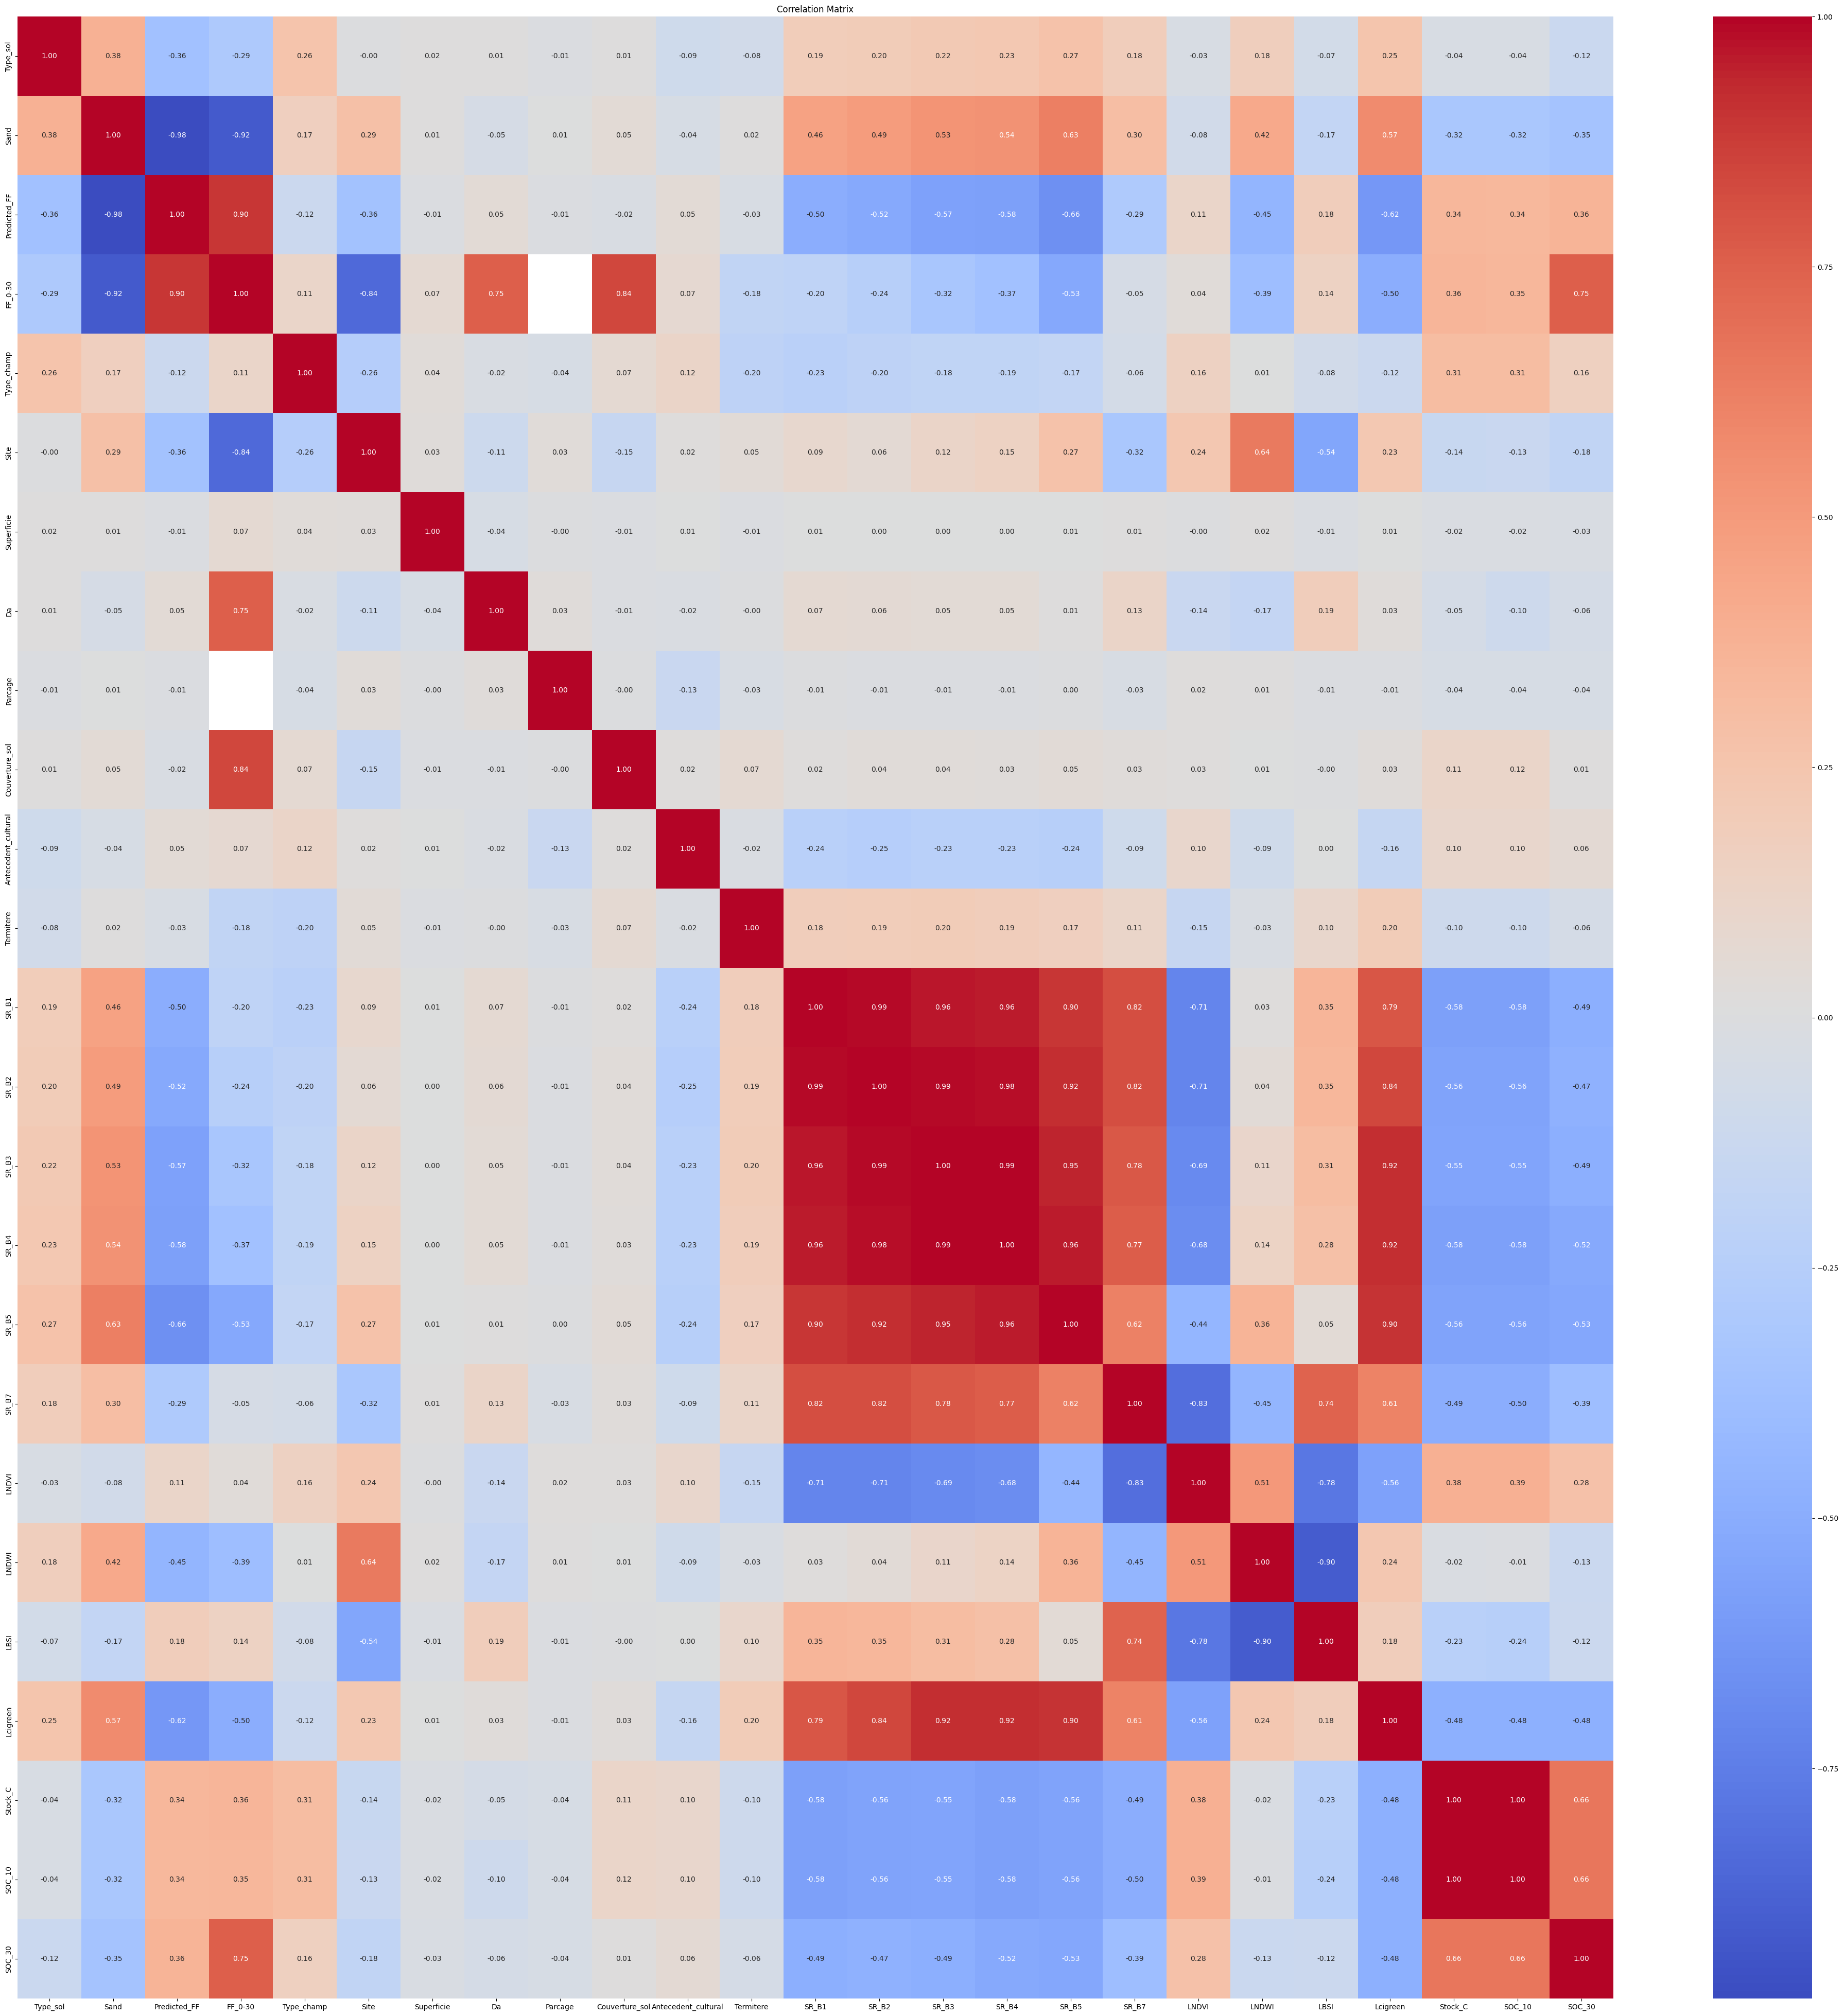

X_Centroid    Y_Centroid  SOC_10  Stock_C  Profondeur(cm)  Depth  \
0      337666.904000  1.613466e+06    7.29    11.08              10    NaN   
1      337665.277100  1.613491e+06   12.36    19.28              10    NaN   
2      337901.175800  1.613567e+06    3.67     5.62              10    NaN   
3      337918.069200  1.613497e+06    5.05     7.88              10    NaN   
4      337909.127500  1.613461e+06    6.51    10.28              10    NaN   
...              ...           ...     ...      ...             ...    ...   
38508  337684.567791  1.602395e+06    3.82     5.92              10    NaN   
38509  336242.852572  1.602357e+06    3.48     5.47              10    NaN   
38510  336184.773989  1.602435e+06    3.50     5.49              10    NaN   
38511  336295.437751  1.602552e+06    2.27     3.57              10    NaN   
38512  337724.804001  1.603323e+06    5.46     8.30              10    NaN   

       Num_Parc_1  Type_sol  Sand  Predicted_FF  ...         SR_B4  \
0           685.0         3  88.1           6.8  ...  14679.331688   
1           345.0         3  85.3           7.4  ...  14612.936821   
2            25.0         2  91.5           3.2  ...  16600.637081   
3           648.0         2  90.2           4.2  ...  16227.502463   
4           675.0         2  88.8           6.0  ...  15320.353406   
...           ...       ...   ...           ...  ...           ...   
38508        53.0         3  88.5           4.8  ...  16552.448174   
38509        54.0         3  89.2           4.6  ...  18055.559289   
38510        55.0         3  89.2           4.7  ...  18124.431953   
38511        56.0         3  91.1           2.5  ...  17943.737931   
38512        49.0         3  88.7           6.0  ...  15901.937747   

              SR_B5         SR_B6         SR_B7  QA_PIXEL     LNDVI     LNDWI  \
0      19777.197433  24596.239882  21141.454097   21824.0  0.147951 -0.108602   
1      19286.111550  24284.315893  21180.730503   21824.0  0.137856 -0.114716   
2      21326.907298  28143.011834  25794.826430   21824.0  0.124613 -0.137783   
3      21110.740887  27282.456158  24554.470936   21824.0  0.130784 -0.127533   
4      20030.712734  25631.906219  23030.277394   21824.0  0.133245 -0.122665   
...             ...           ...           ...       ...       ...       ...   
38508  21299.229023  27955.166831  24787.390918   21824.0  0.125405 -0.135134   
38509  22716.131423  29336.993083  26473.951581   21824.0  0.114309 -0.127194   
38510  22709.339250  29384.819527  26545.734714   21824.0  0.112282 -0.128143   
38511  22896.266995  28867.213793  25181.205911   21824.0  0.121267 -0.115351   
38512  20903.497036  26626.467391  23595.271739   21824.0  0.135892 -0.120408   

           LBSI  Lcigreen  SOC_30  
0      0.132685  0.094934    1.61  
1      0.135156  0.093342    2.88  
2      0.156696  0.100950    2.17  
3      0.149166  0.098049    2.82  
4      0.139686  0.089887    3.25  
...         ...       ...     ...  
38508  0.154409  0.099206    2.23  
38509  0.154744  0.110380    2.79  
38510  0.154504  0.105949    2.07  
38511  0.146552  0.105203    2.14  
38512  0.143470  0.100840    2.30  

[1608 rows x 46 columns]

In [14]:
data_train_landsat_10 = data_train_landsat[data_train_landsat['Profondeur(cm)']==10].copy()
data_train_landsat_30 = data_train_landsat[data_train_landsat['Profondeur(cm)']==30].copy()
data_train_landsat_10_30 = pd.merge(data_train_landsat_10, data_train_landsat_30[['SOC', 'ProfileID']], on='ProfileID', how='left', suffixes=('_10', '_30'))

# DROP DUPLICATE PROFILEID KEEP FIRST

data_train_landsat_10_30 = data_train_landsat_10_30.drop_duplicates(subset=['ProfileID'], keep='first')
corr_matrix = data_train_landsat_10_30[[ 'Type_sol', 'Sand', 'Predicted_FF', 'FF_0-30', 'Type_champ', 'Site', 'Superficie', 'Da', 'Parcage', 'Couverture_sol', 'Antecedent_cultural', 'Termitere','SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7','LNDVI','LNDWI','LBSI','Lcigreen','Stock_C','SOC_10','SOC_30']].corr()
plt.figure(figsize=(50, 50))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
# data_train_landsat_10_30 = data_train_landsat_10_30.dropna(subset=['SOC_10', 'SOC_30', 'Sand', 'Predicted_FF', 'FF_0-30', 'Type_champ', 'Site', 'Superficie', 'Da', 'Parcage', 'Couverture_sol', 'Antecedent_cultural', 'Termitere','SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7','LNDVI','LNDWI','LBSI','Lcigreen'])

data_train_landsat_10_30


#### feature importance

In [15]:
X_10 =  data_train_landsat_10_30[[ 'Type_sol', 'Sand', 'Predicted_FF', 'FF_0-30', 'Type_champ', 'Site', 'Superficie', 'Da', 'Parcage', 'Couverture_sol', 'Antecedent_cultural', 'Termitere','SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7','LNDVI','LNDWI','LBSI', 'Lcigreen']].copy()

Y_10 = data_train_landsat_10_30['SOC_10'].copy()
Y_30 = data_train_landsat_10_30['SOC_30'].copy()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Meilleurs paramètres : {'subsample': 1.0, 'num_leaves': 50, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.01}
Meilleur score R² : 0.39935189467662835
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Meilleurs paramètres : {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Meilleur score R² : 0.410345302480471
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/magaye/Documents/Stage/Sénégal/project/AF-AfSP1.2/env/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleurs paramètres : {'n_estimators': 300, 'max_features': 'log2', 'max_depth': 20}
Meilleur score R² : 0.43166229494827163
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Meilleurs paramètres : {'max_leaf_nodes': 31, 'max_iter': 200, 'max_depth': 5, 'learning_rate': 0.05}
Meilleur score R² : 0.42341653064766077
Model: LGBMRegressor
 feature names: ['LNDVI', 'Superficie', 'SR_B6', 'SR_B5', 'Predicted_FF', 'SR_B1', 'SR_B4', 'Lcigreen', 'SR_B2', 'Sand', 'LNDWI', 'LBSI', 'SR_B3', 'SR_B7', 'Da', 'Type_champ', 'Type_sol', 'Site']
Model: XGBRegressor
 feature names: ['SR_B4', 'SR_B1', 'SR_B5', 'SR_B2', 'SR_B6', 'Type_champ', 'Couverture_sol', 'SR_B3', 'SR_B7', 'Site', 'Type_sol', 'Superficie', 'Predicted_FF', 'Lcigreen', 'LBSI', 'Sand', 'LNDVI', 'LNDWI']
Model: RandomForestRegressor
 feature names: ['SR_B1', 'SR_B2', 'SR_B4', 'SR_B3', 'SR_B5', 'SR_B6', 'Lcigreen', 'SR_B7', 'Predicted_FF', 'LNDVI', 'Sand', 'Superficie', 'LBSI', 'LNDWI', 'Type_champ', 'Da', 'Couverture_sol', 'Si

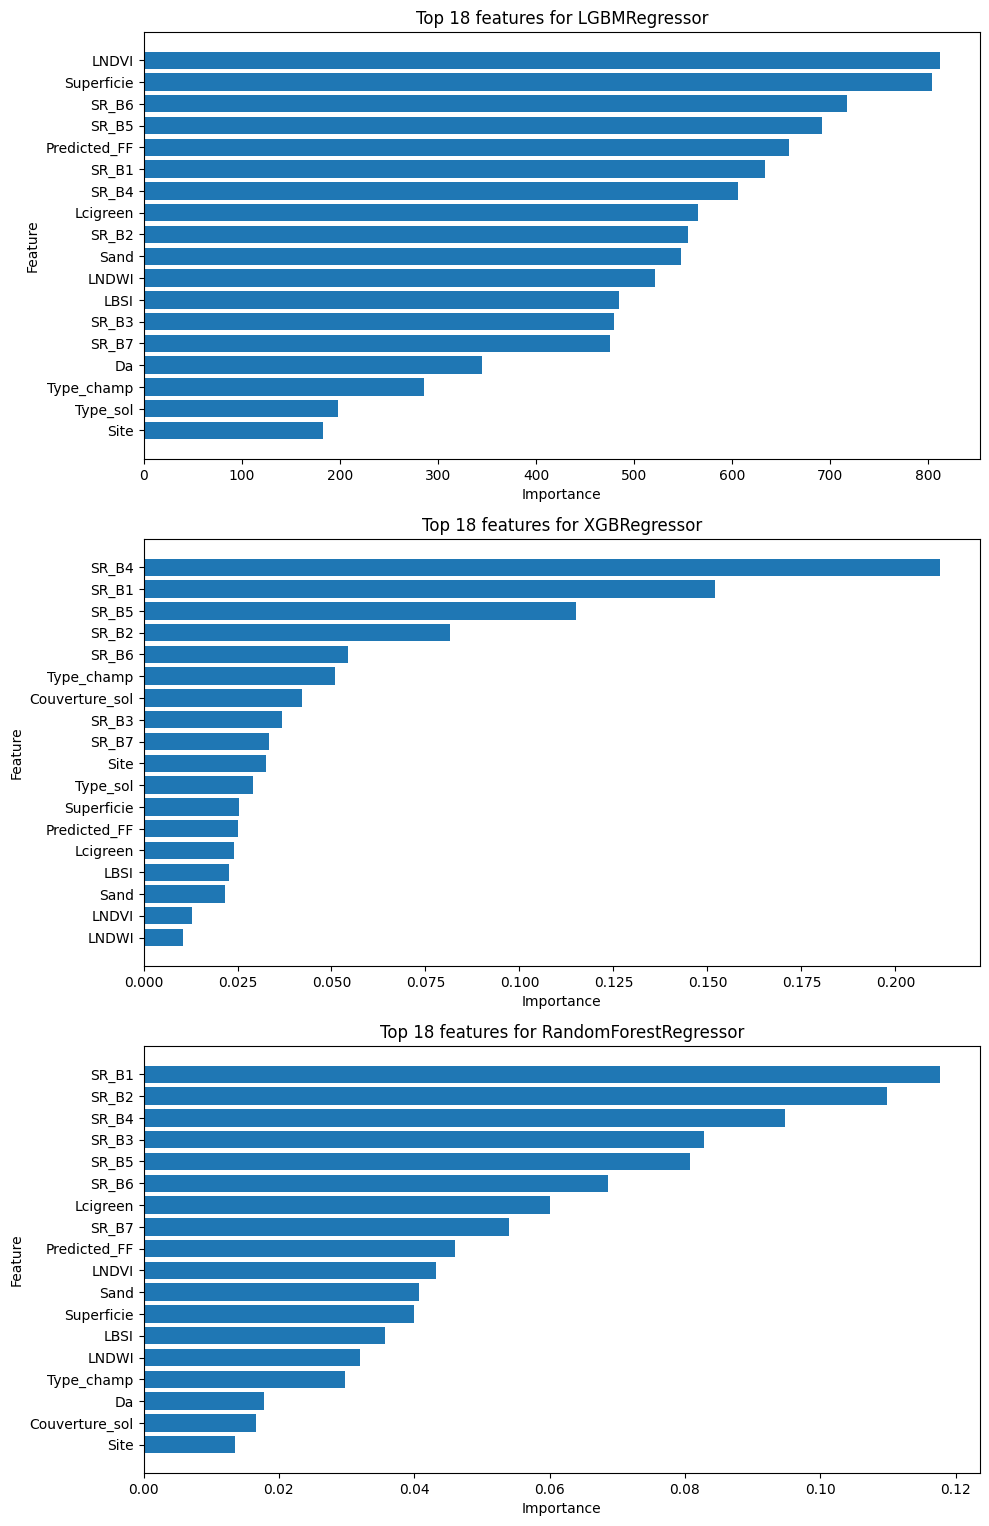

In [17]:

best_lgbm = optimize_model(lgb.LGBMRegressor(force_col_wise=True, verbosity=-1), param_grids["lgbm"], X_10, Y_10)
best_xgb = optimize_model(XGBRegressor(tree_method='hist', verbosity=0), param_grids["xgb"], X_10, Y_10)
best_rf = optimize_model(RandomForestRegressor(bootstrap=True, n_jobs=-1, random_state=42, verbose=0), param_grids["rf"], X_10, Y_10)
best_hgb = optimize_model(HistGradientBoostingRegressor(early_stopping=True,max_iter=500, random_state=42, verbose=0), param_grids["hgb"], X_10, Y_10)
plot_feature_importances([best_lgbm, best_xgb, best_rf, best_hgb], X_10.columns, top_n=18)




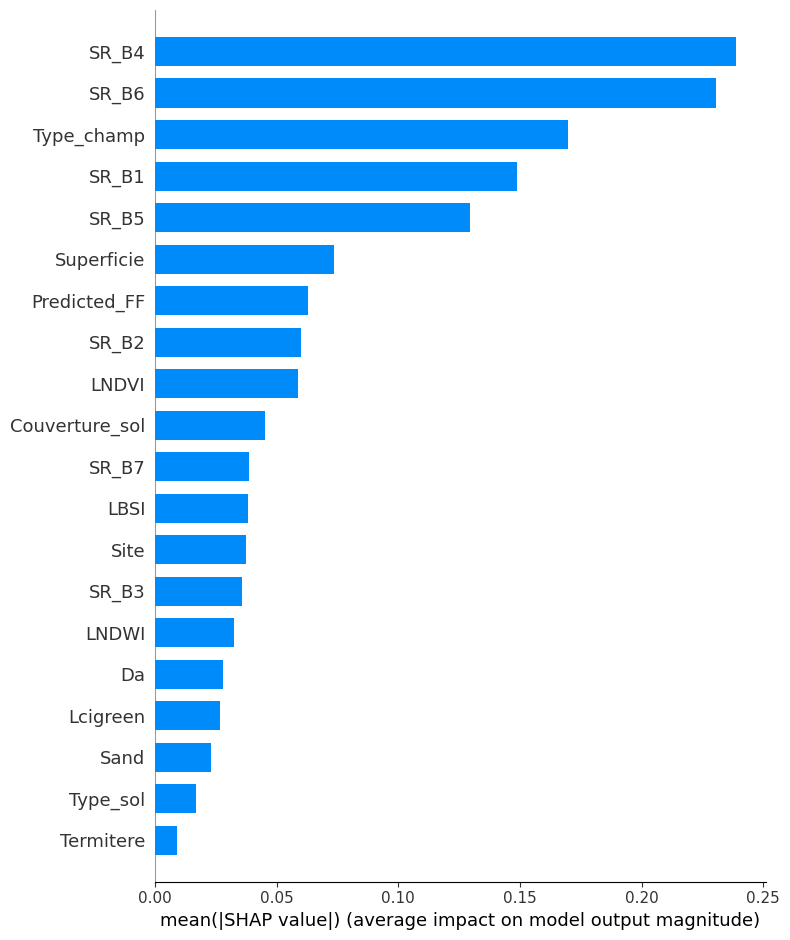

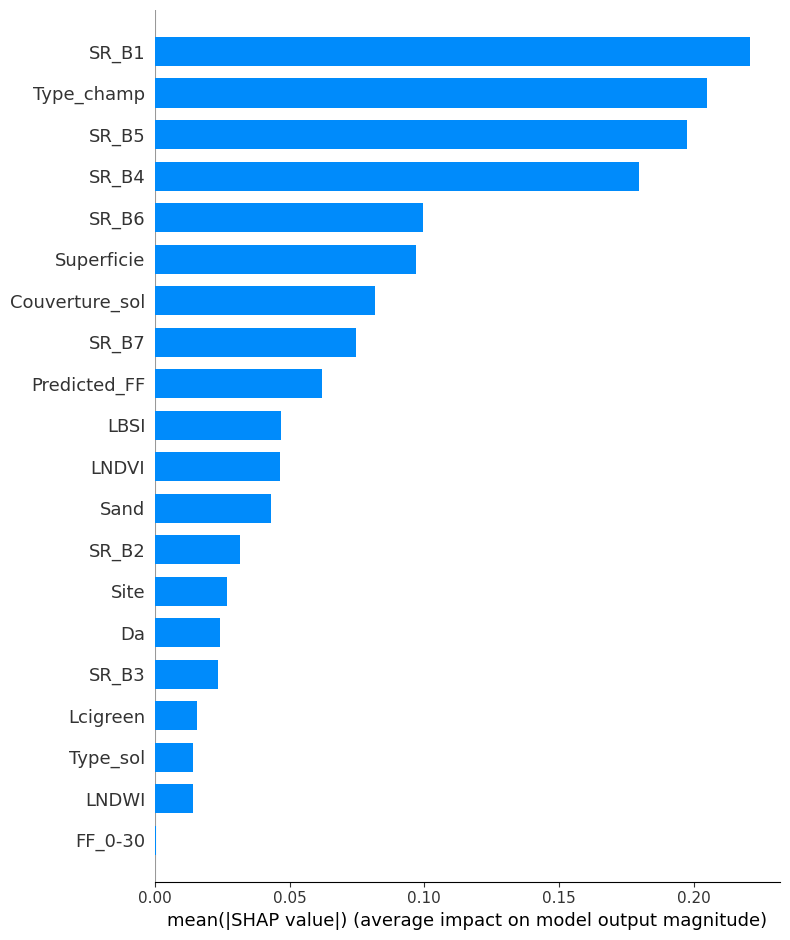

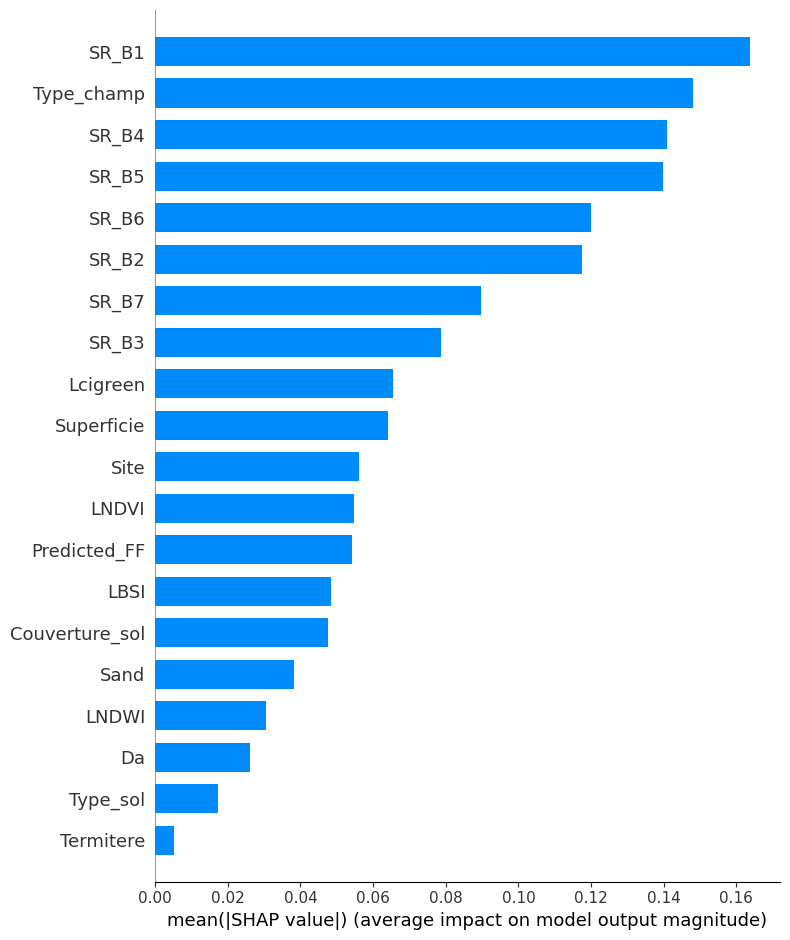

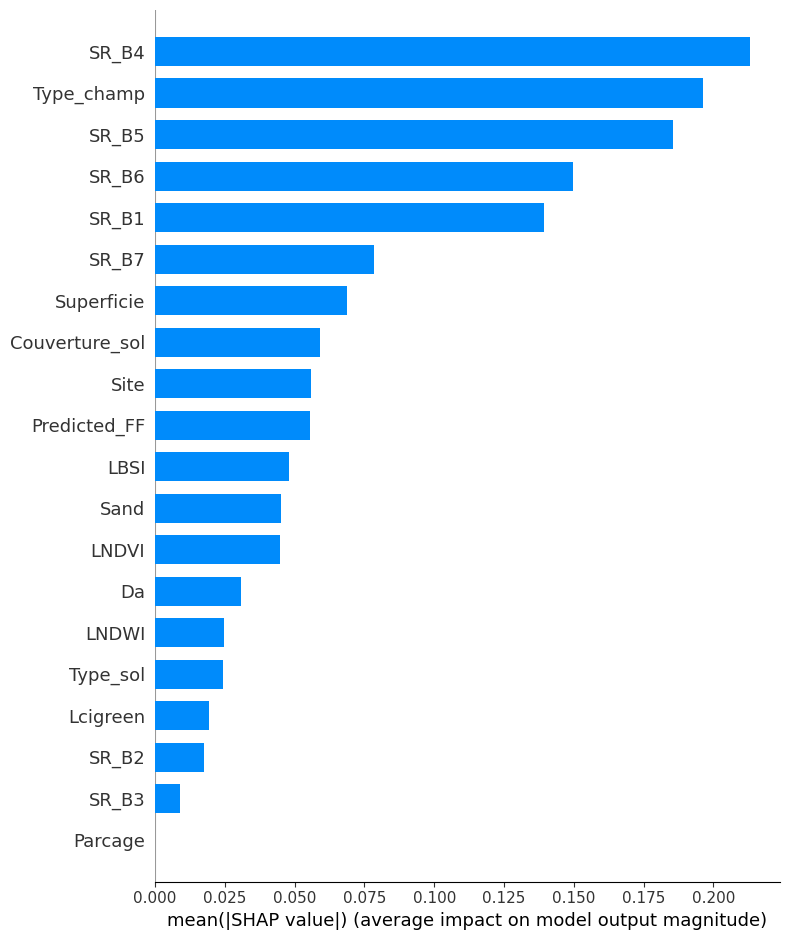

In [18]:
models = [best_lgbm, best_xgb, best_rf, best_hgb]

plt.figure(figsize=(10, 5 * len(models)))
plt.subplots_adjust(hspace=0.5)
for i, model in enumerate(models):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_10)
    shap.summary_plot(shap_values, X_10, plot_type="bar")

### Sentinel

#### load

In [19]:
sentinel_ird_data.head()

ProfileID  Longitude   Latitude  T_Year  Start_Date    End_Date   Satellite  \
0     IRD_4 -16.504652  14.589834    2016  2016-01-01  2016-12-31  Sentinel-2   
1     IRD_1 -16.506981  14.589541    2016  2016-01-01  2016-12-31  Sentinel-2   
2     IRD_6 -16.503821  14.590112    2016  2016-01-01  2016-12-31  Sentinel-2   
3     IRD_8 -16.502787  14.590484    2016  2016-01-01  2016-12-31  Sentinel-2   
4     IRD_2 -16.506998  14.589767    2016  2016-01-01  2016-12-31  Sentinel-2   

   error  VV  VH  ...           B4           B5           B6           B7  \
0    NaN NaN NaN  ...  3092.961538  3256.846154  3610.961538  3965.250000   
1    NaN NaN NaN  ...  3046.600000  3196.600000  3569.200000  3913.200000   
2    NaN NaN NaN  ...  3045.025641  3187.239316  3526.923077  3891.803419   
3    NaN NaN NaN  ...  2979.000000  3134.000000  3477.000000  3855.000000   
4    NaN NaN NaN  ...  3072.800000  3217.600000  3567.600000  3905.000000   

            B8          B8A           B9         B10          B11          B12  
0  3874.326923  4383.788462  1590.807692  344.980769  4033.903846  3329.711538  
1  3869.200000  4344.600000  1568.800000  364.600000  3886.200000  3192.400000  
2  3794.470085  4281.692308  1509.179487  313.846154  4049.290598  3387.452991  
3  3754.000000  4251.000000  1465.000000  287.000000  4228.000000  3517.000000  
4  3840.600000  4321.600000  1565.000000  367.000000  3878.000000  3237.600000  

[5 rows x 23 columns]

In [20]:
data_train_sentinel = pd.merge(data, sentinel_ird_data, on='ProfileID', how='left')
#  # Calcul du NDVI
#     ndvi = (B8 - B4) / (B8 + B4)

#     # Calcul du GDVI
#     gdvi = (B8 - B3) / (B8 + B3)

#     # Calcul du MSAVI2
#     msavi2 = (2 * B8 + 1 - np.sqrt((2 * B8 + 1) ** 2 - 8 * (B8 - B4))) / 2

#     # Calcul du PSRINIR
#     psrinir = B8 / B5

#     # Calcul du NDWI
#     ndwi = (B3 - B8) / (B3 + B8)

#     # Calcul du CIGreen
#     cigreen = (B4 - B3) / (B4 + B3)

data_train_sentinel['SNDVI']= (data_train_sentinel['B8'] - data_train_sentinel['B4']) / (data_train_sentinel['B8'] + data_train_sentinel['B4'])
data_train_sentinel['SGDVI']= (data_train_sentinel['B8'] - data_train_sentinel['B3']) / (data_train_sentinel['B8'] + data_train_sentinel['B3'])
data_train_sentinel['SMSAVI2']= (2 * data_train_sentinel['B8'] + 1 - np.sqrt((2 * data_train_sentinel['B8'] + 1) ** 2 - 8 * (data_train_sentinel['B8'] - data_train_sentinel['B4']))) / 2
data_train_sentinel['SPSRINIR']= data_train_sentinel['B8'] / data_train_sentinel['B5']
data_train_sentinel['SNDWI']= (data_train_sentinel['B3'] - data_train_sentinel['B8']) / (data_train_sentinel['B3'] + data_train_sentinel['B8'])
data_train_sentinel['Scigreen']= (data_train_sentinel['B4'] - data_train_sentinel['B3']) / (data_train_sentinel['B4'] + data_train_sentinel['B3'])



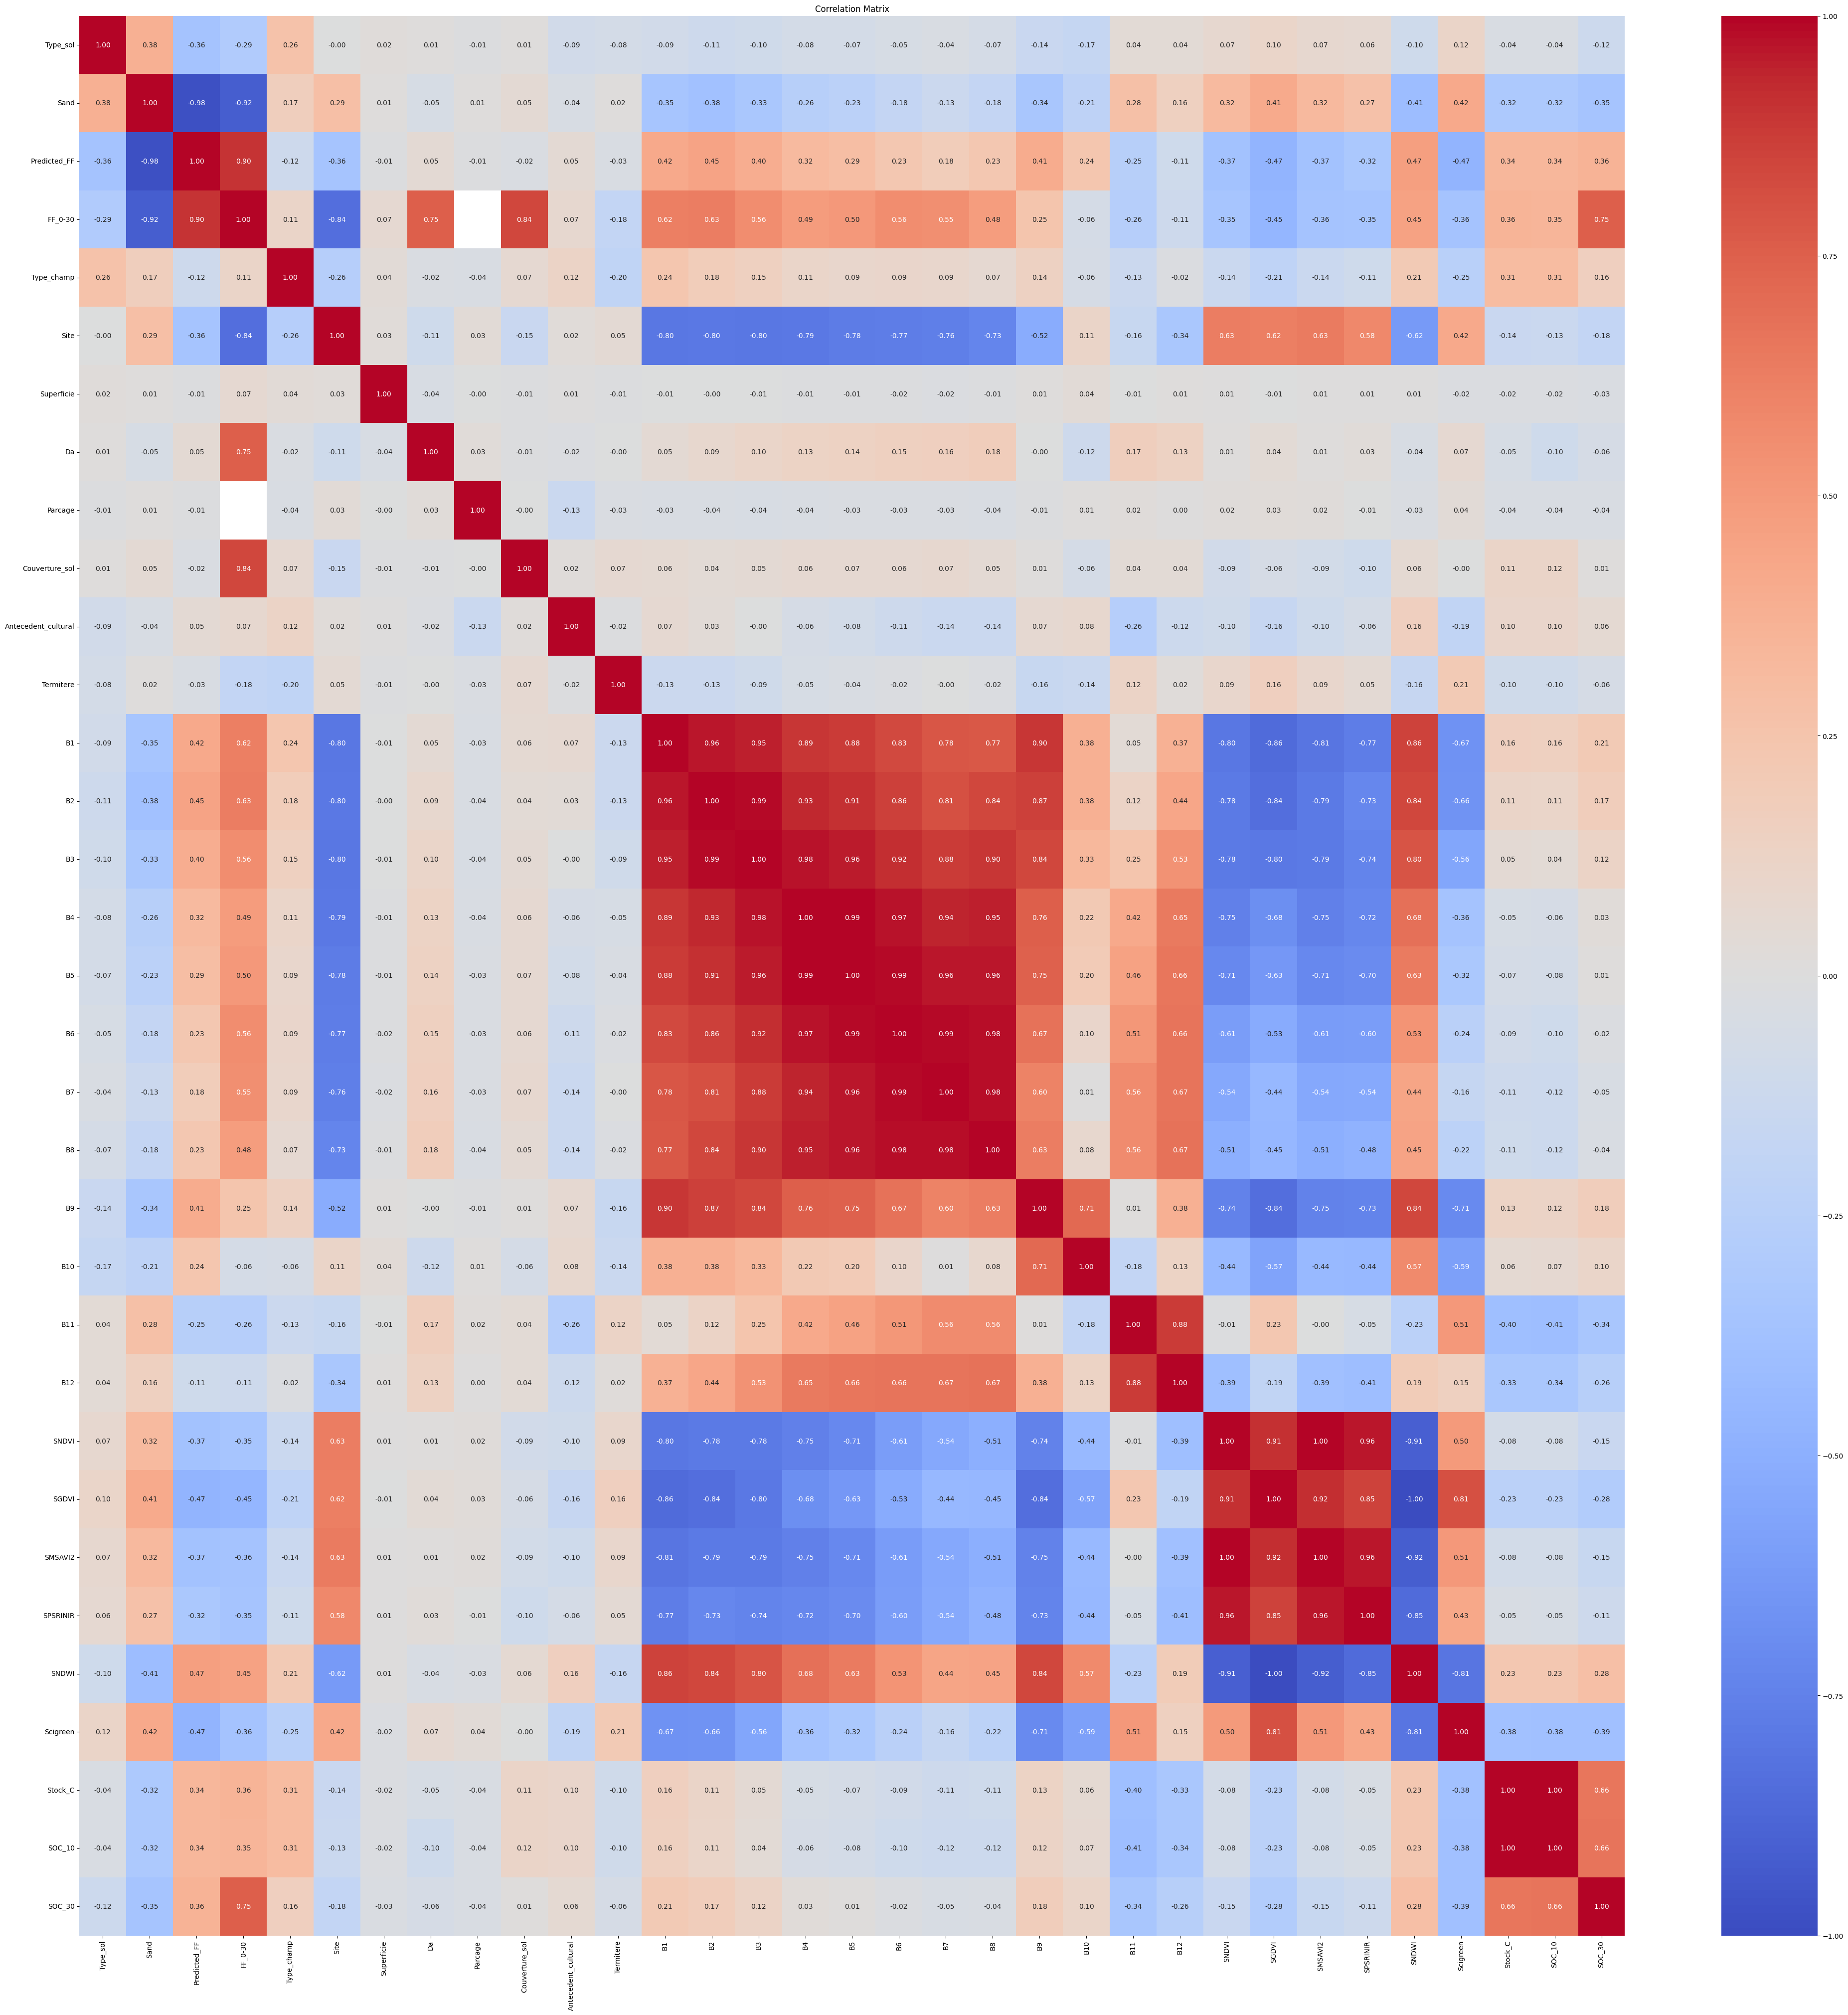

X_Centroid    Y_Centroid  SOC_10  Stock_C  Profondeur(cm)  Depth  \
0      337666.904000  1.613466e+06    7.29    11.08              10    NaN   
1      337665.277100  1.613491e+06   12.36    19.28              10    NaN   
2      337901.175800  1.613567e+06    3.67     5.62              10    NaN   
3      337918.069200  1.613497e+06    5.05     7.88              10    NaN   
4      337909.127500  1.613461e+06    6.51    10.28              10    NaN   
...              ...           ...     ...      ...             ...    ...   
38508  337684.567791  1.602395e+06    3.82     5.92              10    NaN   
38509  336242.852572  1.602357e+06    3.48     5.47              10    NaN   
38510  336184.773989  1.602435e+06    3.50     5.49              10    NaN   
38511  336295.437751  1.602552e+06    2.27     3.57              10    NaN   
38512  337724.804001  1.603323e+06    5.46     8.30              10    NaN   

       Num_Parc_1  Type_sol  Sand  Predicted_FF  ...         B10          B11  \
0           685.0         3  88.1           6.8  ...  364.600000  3886.200000   
1           345.0         3  85.3           7.4  ...  367.000000  3878.000000   
2            25.0         2  91.5           3.2  ...  350.000000  4099.000000   
3           648.0         2  90.2           4.2  ...  344.980769  4033.903846   
4           675.0         2  88.8           6.0  ...  345.800000  3890.800000   
...           ...       ...   ...           ...  ...         ...          ...   
38508        53.0         3  88.5           4.8  ...  397.200000  3530.171429   
38509        54.0         3  89.2           4.6  ...  295.688679  4643.669811   
38510        55.0         3  89.2           4.7  ...  299.023622  4592.921260   
38511        56.0         3  91.1           2.5  ...  297.269841  4582.952381   
38512        49.0         3  88.7           6.0  ...  368.310345  3357.534483   

               B12     SNDVI     SGDVI   SMSAVI2  SPSRINIR     SNDWI  \
0      3192.400000  0.118945  0.193940  0.212580  1.210411 -0.193940   
1      3237.600000  0.111060  0.187276  0.199896  1.193623 -0.187276   
2      3410.000000  0.110825  0.202908  0.199517  1.185309 -0.202908   
3      3329.711538  0.112148  0.202844  0.201657  1.189595 -0.202844   
4      3237.800000  0.106113  0.191096  0.191846  1.173802 -0.191096   
...            ...       ...       ...       ...       ...       ...   
38508  2768.876190  0.122023  0.208214  0.217478  1.216916 -0.208214   
38509  3770.537736  0.122654  0.238707  0.218483  1.207740 -0.238707   
38510  3748.645669  0.132487  0.248174  0.233952  1.234435 -0.248174   
38511  3437.650794  0.139284  0.260136  0.244488  1.222786 -0.260136   
38512  2736.568966  0.086462  0.195222  0.159139  1.106649 -0.195222   

       Scigreen  SOC_30  
0      0.076765    1.61  
1      0.077835    2.88  
2      0.094200    2.17  
3      0.092808    2.82  
4      0.086742    3.25  
...         ...     ...  
38508  0.088438    2.23  
38509  0.119554    2.79  
38510  0.119620    2.07  
38511  0.125395    2.14  
38512  0.110627    2.30  

[1608 rows x 56 columns]

In [21]:
data_train_sentinel_10 = data_train_sentinel[data_train_sentinel['Profondeur(cm)']==10].copy()
data_train_sentinel_30 = data_train_sentinel[data_train_sentinel['Profondeur(cm)']==30].copy()
data_train_sentinel_10_30 = pd.merge(data_train_sentinel_10, data_train_sentinel_30[['SOC', 'ProfileID']], on='ProfileID', how='left', suffixes=('_10', '_30'))

# DROP DUPLICATE PROFILEID KEEP FIRST

data_train_sentinel_10_30 = data_train_sentinel_10_30.drop_duplicates(subset=['ProfileID'], keep='first')
corr_matrix = data_train_sentinel_10_30[[ 'Type_sol', 'Sand', 'Predicted_FF', 'FF_0-30', 'Type_champ', 'Site', 'Superficie', 'Da', 'Parcage', 'Couverture_sol', 'Antecedent_cultural', 'Termitere','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen','Stock_C','SOC_10','SOC_30']].corr()
plt.figure(figsize=(50, 50))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
# data_train_sentinel_10_30 = data_train_sentinel_10_30.dropna(subset=['SOC_10', 'SOC_30', 'Sand', 'Predicted_FF', 'FF_0-30', 'Type_champ', 'Site', 'Superficie', 'Da', 'Parcage', 'Couverture_sol', 'Antecedent_cultural', 'Termitere','SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7','LNDVI','LNDWI','LBSI','Lcigreen'])

data_train_sentinel_10_30


#### feature importance

In [22]:
X_10 =  data_train_sentinel_10_30[[ 'Type_sol', 'Sand', 'Type_champ', 'Site',  'Couverture_sol', 'Antecedent_cultural','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen',]].copy()

Y_10 = data_train_sentinel_10_30['SOC_10'].copy()
Y_30 = data_train_sentinel_10_30['SOC_30'].copy()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Meilleurs paramètres : {'subsample': 1.0, 'num_leaves': 50, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.01}
Meilleur score R² : 0.26845265364928744
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Meilleurs paramètres : {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Meilleur score R² : 0.32135693680953714
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/magaye/Documents/Stage/Sénégal/project/AF-AfSP1.2/env/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleurs paramètres : {'n_estimators': 800, 'max_features': None, 'max_depth': 10}
Meilleur score R² : 0.29884291893774156
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Meilleurs paramètres : {'max_leaf_nodes': 31, 'max_iter': 200, 'max_depth': 5, 'learning_rate': 0.05}
Meilleur score R² : 0.3047746589792011
Model: LGBMRegressor
 feature names: ['Sand', 'Scigreen', 'B12', 'Superficie', 'B9', 'B1', 'B8', 'B10', 'B11', 'B7', 'SPSRINIR', 'SNDVI', 'B4', 'B2', 'B6', 'Type_champ', 'SGDVI', 'Couverture_sol']
Model: XGBRegressor
 feature names: ['Type_champ', 'Scigreen', 'B7', 'B4', 'Sand', 'B8', 'B12', 'B2', 'B6', 'Couverture_sol', 'SGDVI', 'B11', 'Superficie', 'B10', 'B1', 'B5', 'SNDWI', 'B3']
Model: RandomForestRegressor
 feature names: ['Scigreen', 'Sand', 'B12', 'Superficie', 'B7', 'Type_champ', 'B8', 'B10', 'B6', 'B11', 'B4', 'B5', 'B2', 'B9', 'Couverture_sol', 'SPSRINIR', 'B1', 'B3']
Model: HistGradientBoostingRegressor


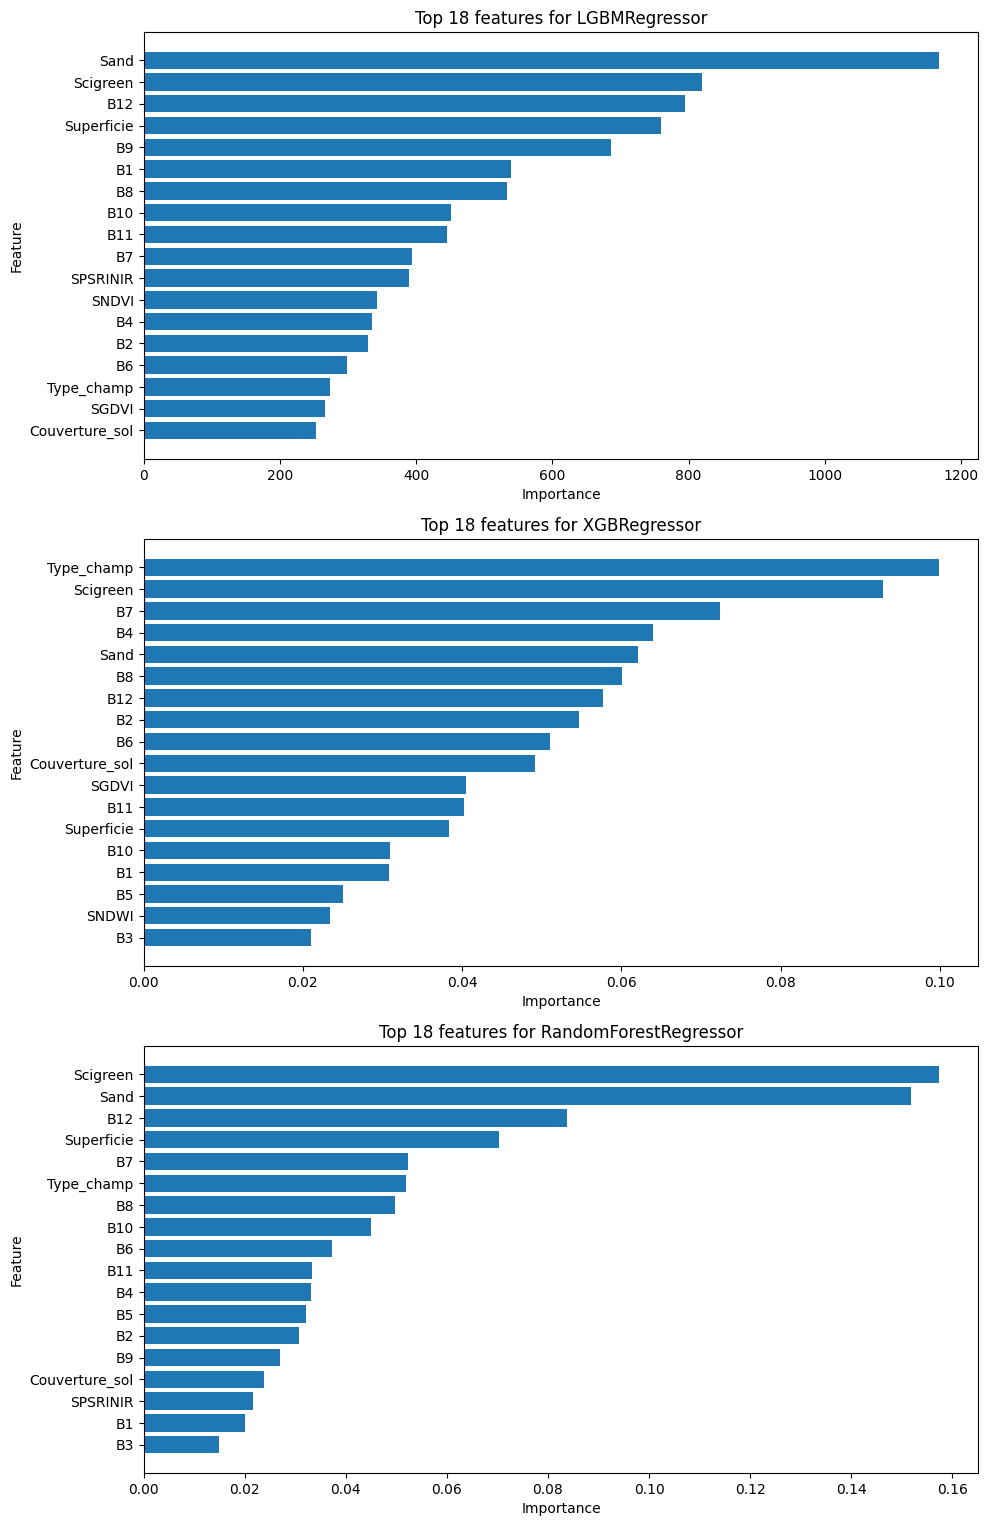

In [23]:
best_lgbm = optimize_model(lgb.LGBMRegressor(force_col_wise=True, verbosity=-1), param_grids["lgbm"], X_10, Y_10)
best_xgb = optimize_model(XGBRegressor(tree_method='hist', verbosity=0), param_grids["xgb"], X_10, Y_10)
best_rf = optimize_model(RandomForestRegressor(bootstrap=True, n_jobs=-1, random_state=42, verbose=0), param_grids["rf"], X_10, Y_10)
best_hgb = optimize_model(HistGradientBoostingRegressor(early_stopping=True,max_iter=500, random_state=42, verbose=0), param_grids["hgb"], X_10, Y_10)
plot_feature_importances([best_lgbm, best_xgb, best_rf, best_hgb], X_10.columns, top_n=18)

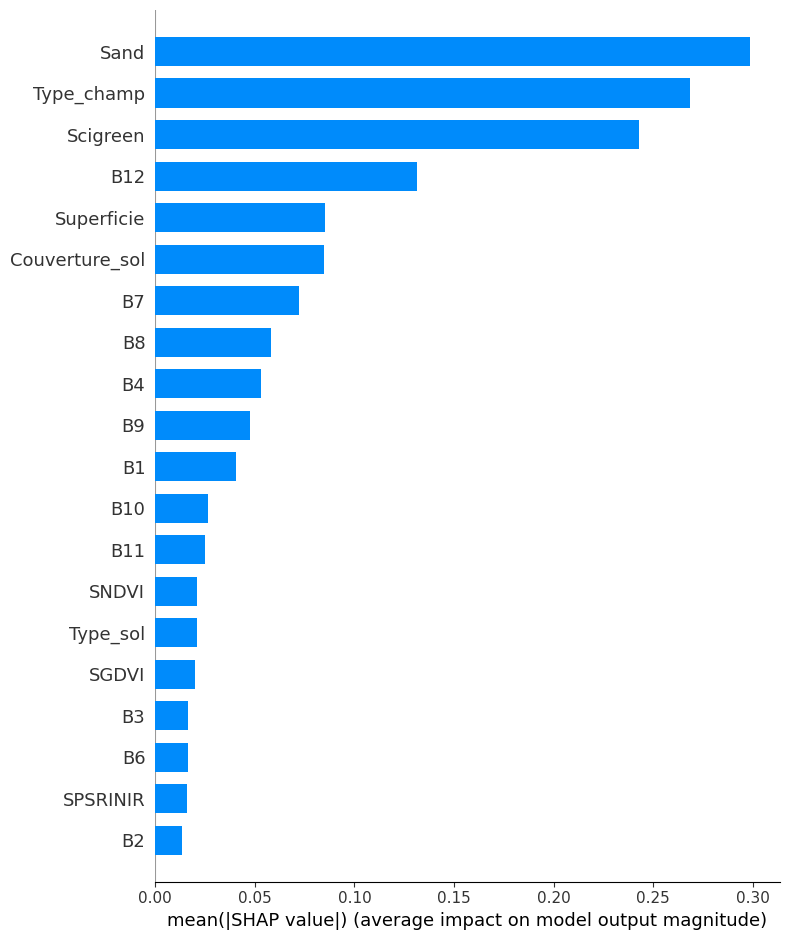

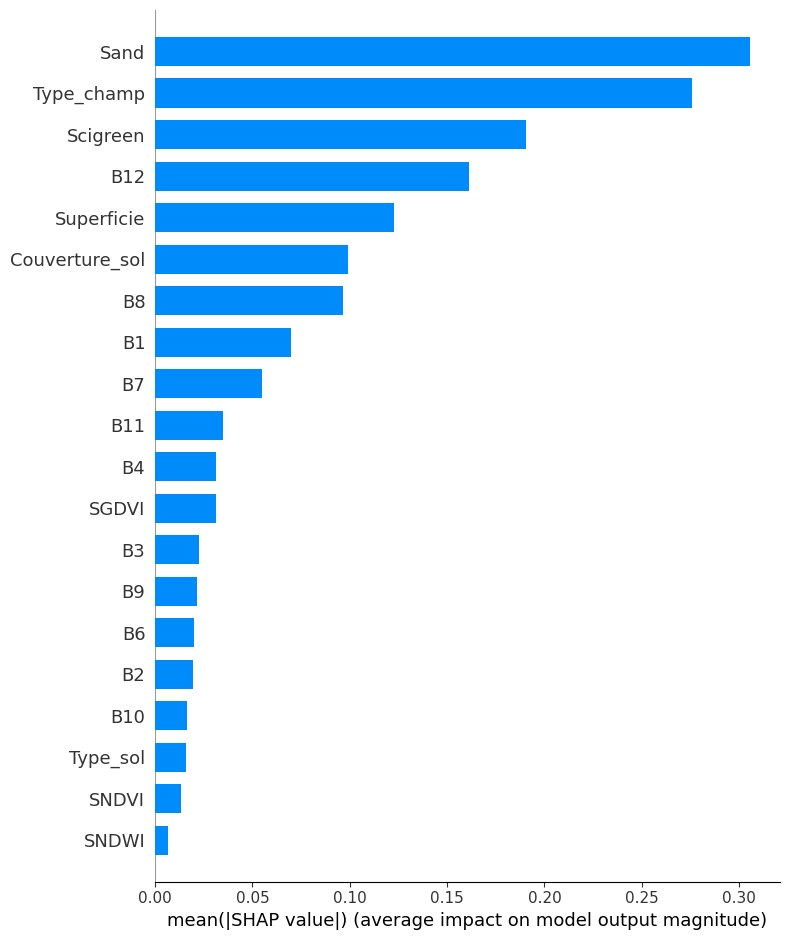

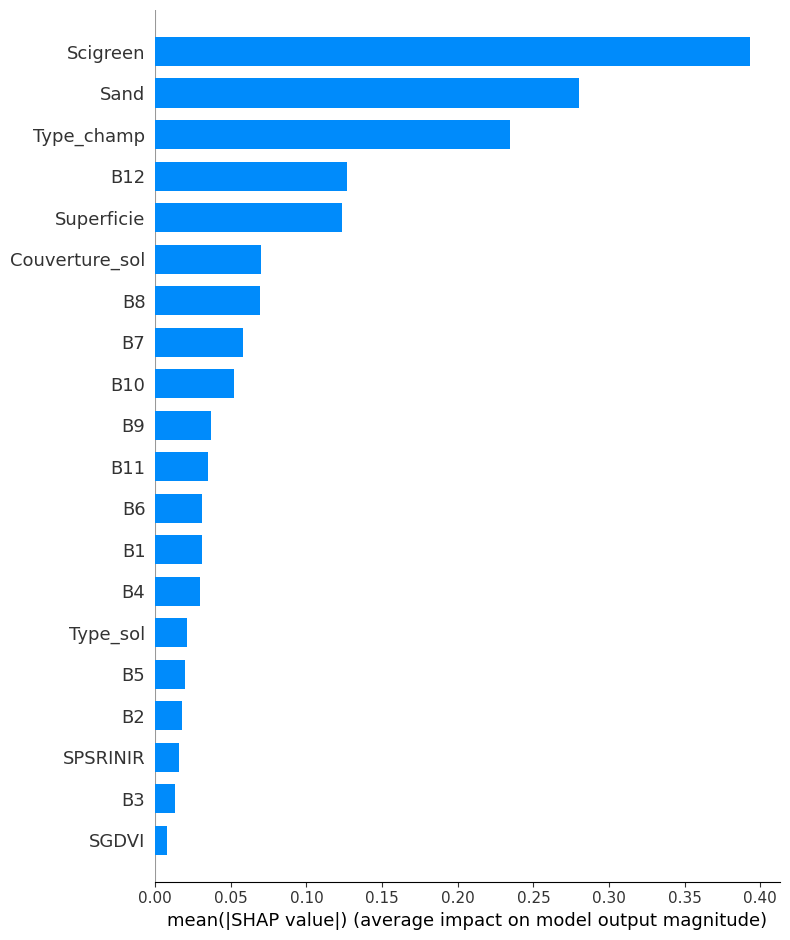

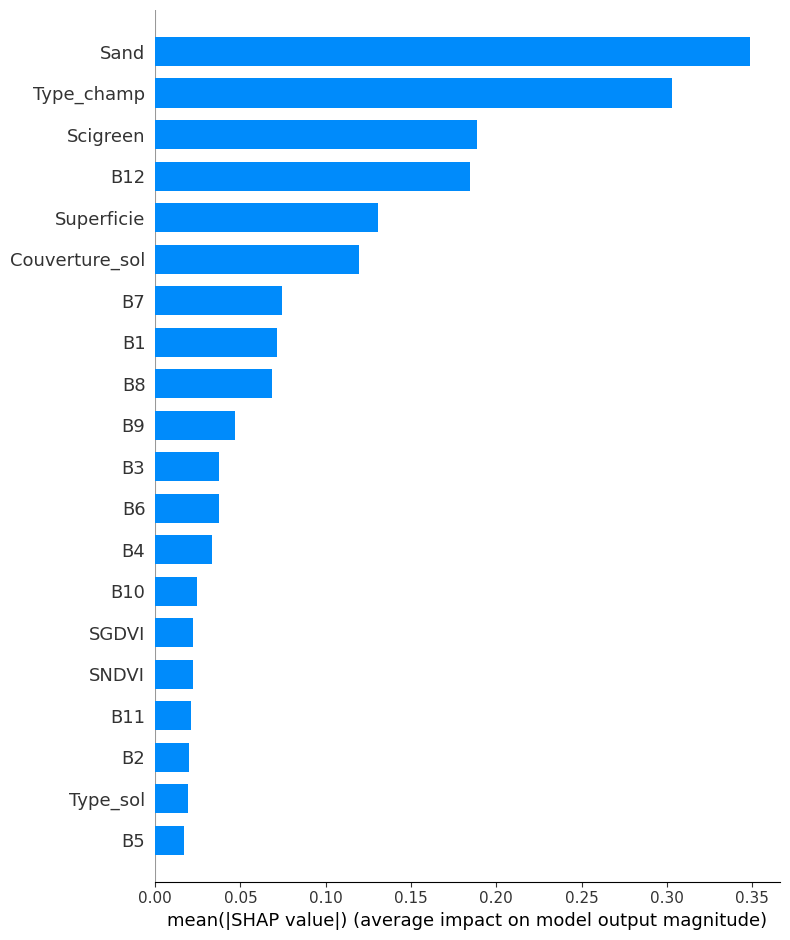

In [24]:
models = [best_lgbm, best_xgb, best_rf, best_hgb]

plt.figure(figsize=(10, 5 * len(models)))
plt.subplots_adjust(hspace=0.5)
for i, model in enumerate(models):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_10)
    shap.summary_plot(shap_values, X_10, plot_type="bar")

## Train

In [25]:


# Définir les modèles individuels
def train(X_train, Y_train,X_test, Y_test, _estimators=[], model=None):
    xgb_model = XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.01, colsample_bytree=0.9, random_state=42)
    lgbmr = lgb.LGBMRegressor(n_estimators=200, max_depth=5, num_leaves=50, learning_rate=0.01, force_col_wise=True, verbosity=-1)
    gbr = GradientBoostingRegressor(n_estimators=200, max_depth=5)
    hgb = HistGradientBoostingRegressor(max_iter=200, max_depth=5, learning_rate=0.05,max_bins=255, max_leaf_nodes=31, min_samples_leaf=20, random_state=42)
    rf = RandomForestRegressor(n_estimators=500, max_depth=None, max_features='log2', random_state=42)

    # Create a scaler that preserves feature names
    class DataFrameScaler:
        def __init__(self):
            self.scaler = StandardScaler()
            self.feature_names = None
            
        def fit(self, X, y=None):
            self.scaler.fit(X)
            self.feature_names = X.columns if hasattr(X, 'columns') else None
            return self
            
        def transform(self, X):
            X_scaled = self.scaler.transform(X)
            if self.feature_names is not None:
                return pd.DataFrame(X_scaled, columns=self.feature_names, index=X.index)
            return X_scaled
            
        def fit_transform(self, X, y=None):
            return self.fit(X, y).transform(X)

    # Créer les pipelines pour chaque modèle
    xgb_pipeline = Pipeline([('scaler', DataFrameScaler()), ('model', xgb_model)])
    lgbmr_pipeline = Pipeline([('scaler', DataFrameScaler()), ('model', lgbmr)])
    gbr_pipeline = Pipeline([('scaler', DataFrameScaler()), ('model', gbr)])
    hgb_pipeline = Pipeline([('scaler', DataFrameScaler()), ('model', hgb)])
    rf_pipeline = Pipeline([('scaler', DataFrameScaler()), ('model', rf)])

    estimators_all = {
        'lgbmr': lgbmr_pipeline,
        'gbr': gbr_pipeline,
        'XGBRegressor': xgb_pipeline,
        'HistGradientBoostingRegressor': hgb_pipeline,  
        'RandomForestRegressor': rf_pipeline
    }

    # Créer l'ensemble de modèles
    estimators = [
        ('lgbmr', lgbmr_pipeline),
        ('gbr', gbr_pipeline),
        ('XGBRegressor', xgb_pipeline),
        ('HistGradientBoostingRegressor', hgb_pipeline),
        ('RandomForestRegressor', rf_pipeline)
    ]
    
    if _estimators:
        estimators = [(key, value) for key, value in estimators_all.items() if key in _estimators]

    Y = Y_train.copy()
    X = X_train.copy()
    
    X_train_split = X.replace([np.inf, -np.inf], np.nan).fillna(X.mean())
    Y_train_split = Y.replace([np.inf, -np.inf], np.nan).fillna(Y.mean())
    
    y = Y_test.copy()
    x = X_test.copy()
    
    X_test_split = x.replace([np.inf, -np.inf], np.nan).fillna(x.mean())
    Y_test_split = y.replace([np.inf, -np.inf], np.nan).fillna(y.mean())

    # X_train_landsat_split, X_test_split, Y_train_split, Y_test_split = train_test_split(X, Y, test_size=0.2, random_state=42)

    for name, model in estimators:
        model.fit(X_train_split, Y_train_split)
        preds = model.predict(X_test_split)
        print(f"{name} - R²: {r2_score(Y_test_split, preds):.3f} - RMSE: {mean_squared_error(Y_test_split, preds):.3f}")

    # Use more stable final estimator
    final_estimator = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=np.logspace(-6, 6, 13))
)

    model = StackingRegressor(
        estimators=estimators,
        final_estimator=final_estimator,
        cv=3)
    history = model.fit(X_train_split, Y_train_split)

    # Calculer les prédictions
    y_train_pred = model.predict(X_train_split)
    y_test_pred = model.predict(X_test_split)

    # Calculer les métriques
    mse_train = mean_squared_error(Y_train_split, y_train_pred)
    mse_test = mean_squared_error(Y_test_split, y_test_pred)

    print("Root Mean Squared Error (MSE) on training set:", np.sqrt(mse_train))
    print("Root Mean Squared Error (MSE) on test set:", np.sqrt(mse_test))

    train_r2 = r2_score(Y_train_split, y_train_pred)
    test_r2 = r2_score(Y_test_split, y_test_pred)
    print("Coefficient de détermination (R²) ON Train:", train_r2)
    print("Coefficient de détermination (R²) ON Test:", test_r2)
    
    return model


def predict(X, model):
    """
    Prédire les valeurs de Y à partir de X en utilisant le modèle donné.
    """
    # Create a scaler that preserves feature names (same as in train)
    class DataFrameScaler:
        def __init__(self):
            self.scaler = StandardScaler()
            self.feature_names = None
            
        def fit(self, X, y=None):
            self.scaler.fit(X)
            self.feature_names = X.columns if hasattr(X, 'columns') else None
            return self
            
        def transform(self, X):
            X_scaled = self.scaler.transform(X)
            if self.feature_names is not None:
                return pd.DataFrame(X_scaled, columns=self.feature_names, index=X.index)
            return X_scaled
            
        def fit_transform(self, X, y=None):
            return self.fit(X, y).transform(X)
    
    # Ensure X is a DataFrame with the same columns as training data
    
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    
    # Scale the data (preserving feature names)
    scaler = DataFrameScaler()
    X_scaled = scaler.fit_transform(X)
    
    return model.predict(X_scaled)

### Landsat

In [28]:
data_train_landsat_10_30

X_Centroid    Y_Centroid  SOC_10  Stock_C  Profondeur(cm)  Depth  \
0      337666.904000  1.613466e+06    7.29    11.08              10    NaN   
1      337665.277100  1.613491e+06   12.36    19.28              10    NaN   
2      337901.175800  1.613567e+06    3.67     5.62              10    NaN   
3      337918.069200  1.613497e+06    5.05     7.88              10    NaN   
4      337909.127500  1.613461e+06    6.51    10.28              10    NaN   
...              ...           ...     ...      ...             ...    ...   
38508  337684.567791  1.602395e+06    3.82     5.92              10    NaN   
38509  336242.852572  1.602357e+06    3.48     5.47              10    NaN   
38510  336184.773989  1.602435e+06    3.50     5.49              10    NaN   
38511  336295.437751  1.602552e+06    2.27     3.57              10    NaN   
38512  337724.804001  1.603323e+06    5.46     8.30              10    NaN   

       Num_Parc_1  Type_sol  Sand  Predicted_FF  ...         SR_B4  \
0           685.0         3  88.1           6.8  ...  14679.331688   
1           345.0         3  85.3           7.4  ...  14612.936821   
2            25.0         2  91.5           3.2  ...  16600.637081   
3           648.0         2  90.2           4.2  ...  16227.502463   
4           675.0         2  88.8           6.0  ...  15320.353406   
...           ...       ...   ...           ...  ...           ...   
38508        53.0         3  88.5           4.8  ...  16552.448174   
38509        54.0         3  89.2           4.6  ...  18055.559289   
38510        55.0         3  89.2           4.7  ...  18124.431953   
38511        56.0         3  91.1           2.5  ...  17943.737931   
38512        49.0         3  88.7           6.0  ...  15901.937747   

              SR_B5         SR_B6         SR_B7  QA_PIXEL     LNDVI     LNDWI  \
0      19777.197433  24596.239882  21141.454097   21824.0  0.147951 -0.108602   
1      19286.111550  24284.315893  21180.730503   21824.0  0.137856 -0.114716   
2      21326.907298  28143.011834  25794.826430   21824.0  0.124613 -0.137783   
3      21110.740887  27282.456158  24554.470936   21824.0  0.130784 -0.127533   
4      20030.712734  25631.906219  23030.277394   21824.0  0.133245 -0.122665   
...             ...           ...           ...       ...       ...       ...   
38508  21299.229023  27955.166831  24787.390918   21824.0  0.125405 -0.135134   
38509  22716.131423  29336.993083  26473.951581   21824.0  0.114309 -0.127194   
38510  22709.339250  29384.819527  26545.734714   21824.0  0.112282 -0.128143   
38511  22896.266995  28867.213793  25181.205911   21824.0  0.121267 -0.115351   
38512  20903.497036  26626.467391  23595.271739   21824.0  0.135892 -0.120408   

           LBSI  Lcigreen  SOC_30  
0      0.132685  0.094934    1.61  
1      0.135156  0.093342    2.88  
2      0.156696  0.100950    2.17  
3      0.149166  0.098049    2.82  
4      0.139686  0.089887    3.25  
...         ...       ...     ...  
38508  0.154409  0.099206    2.23  
38509  0.154744  0.110380    2.79  
38510  0.154504  0.105949    2.07  
38511  0.146552  0.105203    2.14  
38512  0.143470  0.100840    2.30  

[1608 rows x 46 columns]

In [29]:
X_10 =  data_train_landsat_10_30[[ 'Type_sol', 'Sand', 'Predicted_FF', 'FF_0-30', 'Type_champ', 'Site',  'Da', 'Parcage', 'Couverture_sol', 'Antecedent_cultural', 'Termitere','SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7','LNDVI','LNDWI','LBSI', 'Lcigreen']].copy()

Y_10 = data_train_landsat_10_30['SOC_10'].copy()
Y_30 = data_train_landsat_10_30['SOC_30'].copy()

groups = data_train_landsat_10_30["Site"]  # colonne identifiant le village
gkf = GroupKFold(n_splits=3)
for train_idx, test_idx in gkf.split(X_10, Y_10, groups):
    X_train_landsat_split, X_test_split = X_10.iloc[train_idx], X_10.iloc[test_idx]
    Y_train_split_10, Y_test_split_10 = Y_10.iloc[train_idx], Y_10.iloc[test_idx]
    Y_train_split_30, Y_test_split_30 = Y_30.iloc[train_idx], Y_30.iloc[test_idx]



In [30]:

model_10=train(X_train_landsat_split[['SR_B1', 'SR_B4', 'SR_B2', 'SR_B5', 'SR_B3', 'SR_B6', 'SR_B7', 'Lcigreen', 'LNDVI','LBSI',  'LNDWI',  ]], Y_train_split_10, X_test_split[['SR_B1', 'SR_B4', 'SR_B2', 'SR_B5', 'SR_B3', 'SR_B6', 'SR_B7', 'Lcigreen', 'LNDVI', 'LBSI', 'LNDWI',]], Y_test_split_10,)


lgbmr - R²: 0.575 - RMSE: 1.100
gbr - R²: 0.389 - RMSE: 1.583
XGBRegressor - R²: 0.523 - RMSE: 1.237
HistGradientBoostingRegressor - R²: 0.584 - RMSE: 1.077
RandomForestRegressor - R²: 0.561 - RMSE: 1.138
Root Mean Squared Error (MSE) on training set: 0.8664238842228195
Root Mean Squared Error (MSE) on test set: 1.1930335487620791
Coefficient de détermination (R²) ON Train: 0.7188239144176867
Coefficient de détermination (R²) ON Test: 0.45045614238118714


In [31]:

model_10=train(X_train_landsat_split[['SR_B1', 'SR_B4', 'SR_B2', 'SR_B5', 'SR_B3', 'SR_B6', 'SR_B7', 'Lcigreen', 'LNDVI', 'Type_champ', 'Predicted_FF', 'Sand', 'LBSI', , 'LNDWI', 'Da', 'Site', 'Couverture_sol']], Y_train_split_10, X_test_split[['SR_B1', 'SR_B4', 'SR_B2', 'SR_B5', 'SR_B3', 'SR_B6', 'SR_B7', 'Lcigreen', 'LNDVI', 'Type_champ', 'Predicted_FF', 'Sand', 'LBSI', 'Superficie', 'LNDWI', 'Da', 'Site', 'Couverture_sol']], Y_test_split_10,)
"""

lgbmr - R²: 0.514 - RMSE: 0.677
gbr - R²: 0.516 - RMSE: 0.675
XGBRegressor - R²: 0.489 - RMSE: 0.713
HistGradientBoostingRegressor - R²: 0.530 - RMSE: 0.655
RandomForestRegressor - R²: 0.520 - RMSE: 0.669
Root Mean Squared Error (MSE) on training set: 0.8068557573716076
Root Mean Squared Error (MSE) on test set: 0.8582151086717326
Coefficient de détermination (R²) ON Train: 0.5117415887674917
Coefficient de détermination (R²) ON Test: 0.4718509659115502
"""

lgbmr - R²: 0.631 - RMSE: 0.957
gbr - R²: 0.521 - RMSE: 1.241
XGBRegressor - R²: 0.569 - RMSE: 1.117
HistGradientBoostingRegressor - R²: 0.676 - RMSE: 0.840
RandomForestRegressor - R²: 0.629 - RMSE: 0.961
Root Mean Squared Error (MSE) on training set: 0.838670529157708
Root Mean Squared Error (MSE) on test set: 1.0472729580551012
Coefficient de détermination (R²) ON Train: 0.7365487196823286
Coefficient de détermination (R²) ON Test: 0.5765356793070371


'\n\nlgbmr - R²: 0.514 - RMSE: 0.677\ngbr - R²: 0.516 - RMSE: 0.675\nXGBRegressor - R²: 0.489 - RMSE: 0.713\nHistGradientBoostingRegressor - R²: 0.530 - RMSE: 0.655\nRandomForestRegressor - R²: 0.520 - RMSE: 0.669\nRoot Mean Squared Error (MSE) on training set: 0.8068557573716076\nRoot Mean Squared Error (MSE) on test set: 0.8582151086717326\nCoefficient de détermination (R²) ON Train: 0.5117415887674917\nCoefficient de détermination (R²) ON Test: 0.4718509659115502\n'

In [32]:

model_10=train(X_train_landsat_split[['SR_B1', 'SR_B4', 'SR_B2', 'SR_B5', 'SR_B3', 'SR_B6', 'SR_B7',]], Y_train_split_10, X_test_split[['SR_B1', 'SR_B4', 'SR_B2', 'SR_B5', 'SR_B3', 'SR_B6', 'SR_B7']], Y_test_split_10,)


lgbmr - R²: 0.575 - RMSE: 1.100
gbr - R²: 0.448 - RMSE: 1.430
XGBRegressor - R²: 0.552 - RMSE: 1.159
HistGradientBoostingRegressor - R²: 0.568 - RMSE: 1.118
RandomForestRegressor - R²: 0.557 - RMSE: 1.148
Root Mean Squared Error (MSE) on training set: 0.8638365972137276
Root Mean Squared Error (MSE) on test set: 1.2189994920645733
Coefficient de détermination (R²) ON Train: 0.7205006849990575
Coefficient de détermination (R²) ON Test: 0.4262745775038854


In [33]:

model_10=train(X_train_landsat_split[['SR_B1', 'SR_B4', 'SR_B2', 'SR_B5', 'SR_B3', 'SR_B6', 'SR_B7', 'Lcigreen', 'LNDVI', 'Type_champ', 'Sand', 'LBSI', 'Superficie', 'LNDWI', 'Site', 'Couverture_sol']], Y_train_split_10, X_test_split[['SR_B1', 'SR_B4', 'SR_B2', 'SR_B5', 'SR_B3', 'SR_B6', 'SR_B7', 'Lcigreen', 'LNDVI', 'Type_champ', 'Sand', 'LBSI',  'LNDWI', 'Site', 'Couverture_sol']], Y_test_split_10,)


lgbmr - R²: 0.626 - RMSE: 0.967
gbr - R²: 0.538 - RMSE: 1.198
XGBRegressor - R²: 0.569 - RMSE: 1.116
HistGradientBoostingRegressor - R²: 0.654 - RMSE: 0.896
RandomForestRegressor - R²: 0.607 - RMSE: 1.018
Root Mean Squared Error (MSE) on training set: 0.6916420515813576
Root Mean Squared Error (MSE) on test set: 1.0538674961010235
Coefficient de détermination (R²) ON Train: 0.8208237966850309
Coefficient de détermination (R²) ON Test: 0.571185892100875


In [34]:
X_train =X_train_landsat_split[['SR_B1', 'SR_B4', 'SR_B2', 'SR_B5', 'SR_B3', 'SR_B6', 'SR_B7', 'Lcigreen', 'LNDVI', 'Type_champ', 'Sand', 'LBSI',  'LNDWI', 'Site', 'Couverture_sol']].copy()
X_test = X_test_split[['SR_B1', 'SR_B4', 'SR_B2', 'SR_B5', 'SR_B3', 'SR_B6', 'SR_B7', 'Lcigreen', 'LNDVI', 'Type_champ', 'Sand', 'LBSI',  'LNDWI', 'Site', 'Couverture_sol']].copy()
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
X_train_landsat_split['Predicted_SOC_10'] = predict(X_train, model_10)
X_test_split['Predicted_SOC_10'] = predict(X_test, model_10)


/tmp/ipykernel_612303/1869347513.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_landsat_split['Predicted_SOC_10'] = predict(X_train, model_10)
/tmp/ipykernel_612303/1869347513.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_split['Predicted_SOC_10'] = predict(X_test, model_10)


In [35]:
model_30=train(X_train_landsat_split[['SR_B1', 'SR_B4', 'SR_B2', 'SR_B5', 'SR_B3', 'SR_B6', 'SR_B7', 'Lcigreen', 'LNDVI', 'Type_champ', 'Sand', 'LBSI',  'LNDWI', 'Site', 'Couverture_sol']], Y_train_split_30, X_test_split[['SR_B1', 'SR_B4', 'SR_B2', 'SR_B5', 'SR_B3', 'SR_B6', 'SR_B7', 'Lcigreen', 'LNDVI', 'Type_champ', 'Sand', 'LBSI',  'LNDWI', 'Site', 'Couverture_sol']], Y_test_split_30,)

lgbmr - R²: 0.346 - RMSE: 1.075
gbr - R²: 0.311 - RMSE: 1.132
XGBRegressor - R²: 0.295 - RMSE: 1.158
HistGradientBoostingRegressor - R²: 0.400 - RMSE: 0.987
RandomForestRegressor - R²: 0.366 - RMSE: 1.042
Root Mean Squared Error (MSE) on training set: 0.8055177528358185
Root Mean Squared Error (MSE) on test set: 1.0483546073281849
Coefficient de détermination (R²) ON Train: 0.5695771273170331
Coefficient de détermination (R²) ON Test: 0.3313263372252053


In [36]:
model_30=train(X_train_landsat_split[['SR_B1', 'SR_B4', 'SR_B2', 'SR_B5', 'SR_B3', 'SR_B6', 'SR_B7', 'Lcigreen', 'LNDVI', 'Type_champ', 'Sand', 'LBSI', 'Superficie', 'LNDWI', 'Site', 'Couverture_sol','Predicted_SOC_10']], Y_train_split_30, X_test_split[['SR_B1', 'SR_B4', 'SR_B2', 'SR_B5', 'SR_B3', 'SR_B6', 'SR_B7', 'Lcigreen', 'LNDVI', 'Type_champ', 'Sand', 'LBSI',  'LNDWI', 'Site', 'Couverture_sol','Predicted_SOC_10']], Y_test_split_30,)

lgbmr - R²: 0.347 - RMSE: 1.074
gbr - R²: 0.324 - RMSE: 1.111
XGBRegressor - R²: 0.296 - RMSE: 1.157
HistGradientBoostingRegressor - R²: 0.390 - RMSE: 1.003
RandomForestRegressor - R²: 0.371 - RMSE: 1.034
Root Mean Squared Error (MSE) on training set: 0.7979724305323482
Root Mean Squared Error (MSE) on test set: 1.0541746152534184
Coefficient de détermination (R²) ON Train: 0.5776029435282093
Coefficient de détermination (R²) ON Test: 0.3238813592342026


### sentinel

In [37]:
X_10 =  data_train_sentinel_10_30[[ 'Type_sol', 'Sand', 'Type_champ', 'Site', 'Superficie', 'Couverture_sol', 'Antecedent_cultural','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen',]].copy()

Y_10 = data_train_sentinel_10_30['SOC_10'].copy()
Y_30 = data_train_sentinel_10_30['SOC_30'].copy()

groups = data_train_sentinel_10_30["Site"]  # colonne identifiant le village
gkf = GroupKFold(n_splits=3)
for train_idx, test_idx in gkf.split(X_10, Y_10, groups):
    X_train_sentinel_split, X_test_split = X_10.iloc[train_idx], X_10.iloc[test_idx]
    Y_train_split_10, Y_test_split_10 = Y_10.iloc[train_idx], Y_10.iloc[test_idx]
    Y_train_split_30, Y_test_split_30 = Y_30.iloc[train_idx], Y_30.iloc[test_idx]


In [38]:
model_10 = train(X_train_sentinel_split[[ 'Type_sol', 'Sand', 'Type_champ', 'Site', 'Couverture_sol', 'Antecedent_cultural','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen',]], Y_train_split_10, X_test_split[[ 'Type_sol', 'Sand', 'Type_champ', 'Site', 'Superficie',  'Couverture_sol', 'Antecedent_cultural','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen',]], Y_test_split_10,)

lgbmr - R²: 0.580 - RMSE: 1.089
gbr - R²: 0.602 - RMSE: 1.031
XGBRegressor - R²: 0.575 - RMSE: 1.101
HistGradientBoostingRegressor - R²: 0.627 - RMSE: 0.965
RandomForestRegressor - R²: 0.567 - RMSE: 1.121
Root Mean Squared Error (MSE) on training set: 0.769446587790932
Root Mean Squared Error (MSE) on test set: 0.9788379993503711
Coefficient de détermination (R²) ON Train: 0.7782444463037971
Coefficient de détermination (R²) ON Test: 0.6300707376026493


In [39]:
model_10 = train(X_train_sentinel_split[[ 'Type_sol', 'Sand', 'Type_champ', 'Site',  'Couverture_sol', 'B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen',]],
                 Y_train_split_10, X_test_split[[ 'Type_sol', 'Sand', 'Type_champ', 'Site',   'Couverture_sol', 'B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen',]], Y_test_split_10,)

lgbmr - R²: 0.561 - RMSE: 1.138
gbr - R²: 0.555 - RMSE: 1.153
XGBRegressor - R²: 0.554 - RMSE: 1.154
HistGradientBoostingRegressor - R²: 0.614 - RMSE: 0.999
RandomForestRegressor - R²: 0.536 - RMSE: 1.201
Root Mean Squared Error (MSE) on training set: 0.7712117046374627
Root Mean Squared Error (MSE) on test set: 0.9972800010670481
Coefficient de détermination (R²) ON Train: 0.777225861166531
Coefficient de détermination (R²) ON Test: 0.6159999639331146


In [40]:
X_train =X_train_sentinel_split[['Type_sol', 'Sand', 'Type_champ', 'Site',  'Couverture_sol', 'B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen',]].copy()
X_test = X_test_split[['Type_sol', 'Sand', 'Type_champ', 'Site',  'Couverture_sol', 'B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen',]].copy()
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
X_train_sentinel_split['Predicted_SOC_10'] = predict(X_train, model_10)
X_test_split['Predicted_SOC_10'] = predict(X_test, model_10)


/tmp/ipykernel_612303/2145951701.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_sentinel_split['Predicted_SOC_10'] = predict(X_train, model_10)
/tmp/ipykernel_612303/2145951701.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_split['Predicted_SOC_10'] = predict(X_test, model_10)


In [41]:
model_30 = train(X_train_sentinel_split[[ 'Type_sol', 'Sand', 'Type_champ', 'Site', 'Superficie', 'Couverture_sol', 'Antecedent_cultural','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen',]], Y_train_split_30, X_test_split[[ 'Type_sol', 'Sand', 'Type_champ', 'Site',   'Couverture_sol', 'Antecedent_cultural','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen',]], Y_test_split_30,)

lgbmr - R²: 0.210 - RMSE: 1.298
gbr - R²: -0.097 - RMSE: 1.804
XGBRegressor - R²: 0.147 - RMSE: 1.403
HistGradientBoostingRegressor - R²: 0.259 - RMSE: 1.217
RandomForestRegressor - R²: 0.186 - RMSE: 1.337
Root Mean Squared Error (MSE) on training set: 0.6597437209714414
Root Mean Squared Error (MSE) on test set: 1.1628712176318672
Coefficient de détermination (R²) ON Train: 0.7112675205981606
Coefficient de détermination (R²) ON Test: 0.17726297065350816


## all

In [42]:
data_train_sentinel_landsat = pd.merge(data_train_sentinel_10_30, data_train_landsat_10_30[['ProfileID', 'SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7','LNDVI','LNDWI','LBSI', 'Lcigreen','X_Centroid','Y_Centroid',]], on='ProfileID', how='left',suffixes=('_S', '_L'))
data_train_sentinel_landsat

X_Centroid_S  Y_Centroid_S  SOC_10  Stock_C  Profondeur(cm)  Depth  \
0     337666.904000  1.613466e+06    7.29    11.08              10    NaN   
1     337665.277100  1.613491e+06   12.36    19.28              10    NaN   
2     337901.175800  1.613567e+06    3.67     5.62              10    NaN   
3     337918.069200  1.613497e+06    5.05     7.88              10    NaN   
4     337909.127500  1.613461e+06    6.51    10.28              10    NaN   
...             ...           ...     ...      ...             ...    ...   
1603  337684.567791  1.602395e+06    3.82     5.92              10    NaN   
1604  336242.852572  1.602357e+06    3.48     5.47              10    NaN   
1605  336184.773989  1.602435e+06    3.50     5.49              10    NaN   
1606  336295.437751  1.602552e+06    2.27     3.57              10    NaN   
1607  337724.804001  1.603323e+06    5.46     8.30              10    NaN   

      Num_Parc_1  Type_sol  Sand  Predicted_FF  ...         SR_B4  \
0          685.0         3  88.1           6.8  ...  14679.331688   
1          345.0         3  85.3           7.4  ...  14612.936821   
2           25.0         2  91.5           3.2  ...  16600.637081   
3          648.0         2  90.2           4.2  ...  16227.502463   
4          675.0         2  88.8           6.0  ...  15320.353406   
...          ...       ...   ...           ...  ...           ...   
1603        53.0         3  88.5           4.8  ...  16552.448174   
1604        54.0         3  89.2           4.6  ...  18055.559289   
1605        55.0         3  89.2           4.7  ...  18124.431953   
1606        56.0         3  91.1           2.5  ...  17943.737931   
1607        49.0         3  88.7           6.0  ...  15901.937747   

             SR_B5         SR_B6         SR_B7     LNDVI     LNDWI      LBSI  \
0     19777.197433  24596.239882  21141.454097  0.147951 -0.108602  0.132685   
1     19286.111550  24284.315893  21180.730503  0.137856 -0.114716  0.135156   
2     21326.907298  28143.011834  25794.826430  0.124613 -0.137783  0.156696   
3     21110.740887  27282.456158  24554.470936  0.130784 -0.127533  0.149166   
4     20030.712734  25631.906219  23030.277394  0.133245 -0.122665  0.139686   
...            ...           ...           ...       ...       ...       ...   
1603  21299.229023  27955.166831  24787.390918  0.125405 -0.135134  0.154409   
1604  22716.131423  29336.993083  26473.951581  0.114309 -0.127194  0.154744   
1605  22709.339250  29384.819527  26545.734714  0.112282 -0.128143  0.154504   
1606  22896.266995  28867.213793  25181.205911  0.121267 -0.115351  0.146552   
1607  20903.497036  26626.467391  23595.271739  0.135892 -0.120408  0.143470   

      Lcigreen   X_Centroid_L  Y_Centroid_L  
0     0.094934  337666.904000  1.613466e+06  
1     0.093342  337665.277100  1.613491e+06  
2     0.100950  337901.175800  1.613567e+06  
3     0.098049  337918.069200  1.613497e+06  
4     0.089887  337909.127500  1.613461e+06  
...        ...            ...           ...  
1603  0.099206  337684.567791  1.602395e+06  
1604  0.110380  336242.852572  1.602357e+06  
1605  0.105949  336184.773989  1.602435e+06  
1606  0.105203  336295.437751  1.602552e+06  
1607  0.100840  337724.804001  1.603323e+06  

[1608 rows x 69 columns]

In [43]:
data_train_sentinel_landsat.to_csv("data_train_sentinel_landsat_brute.csv", index=False)

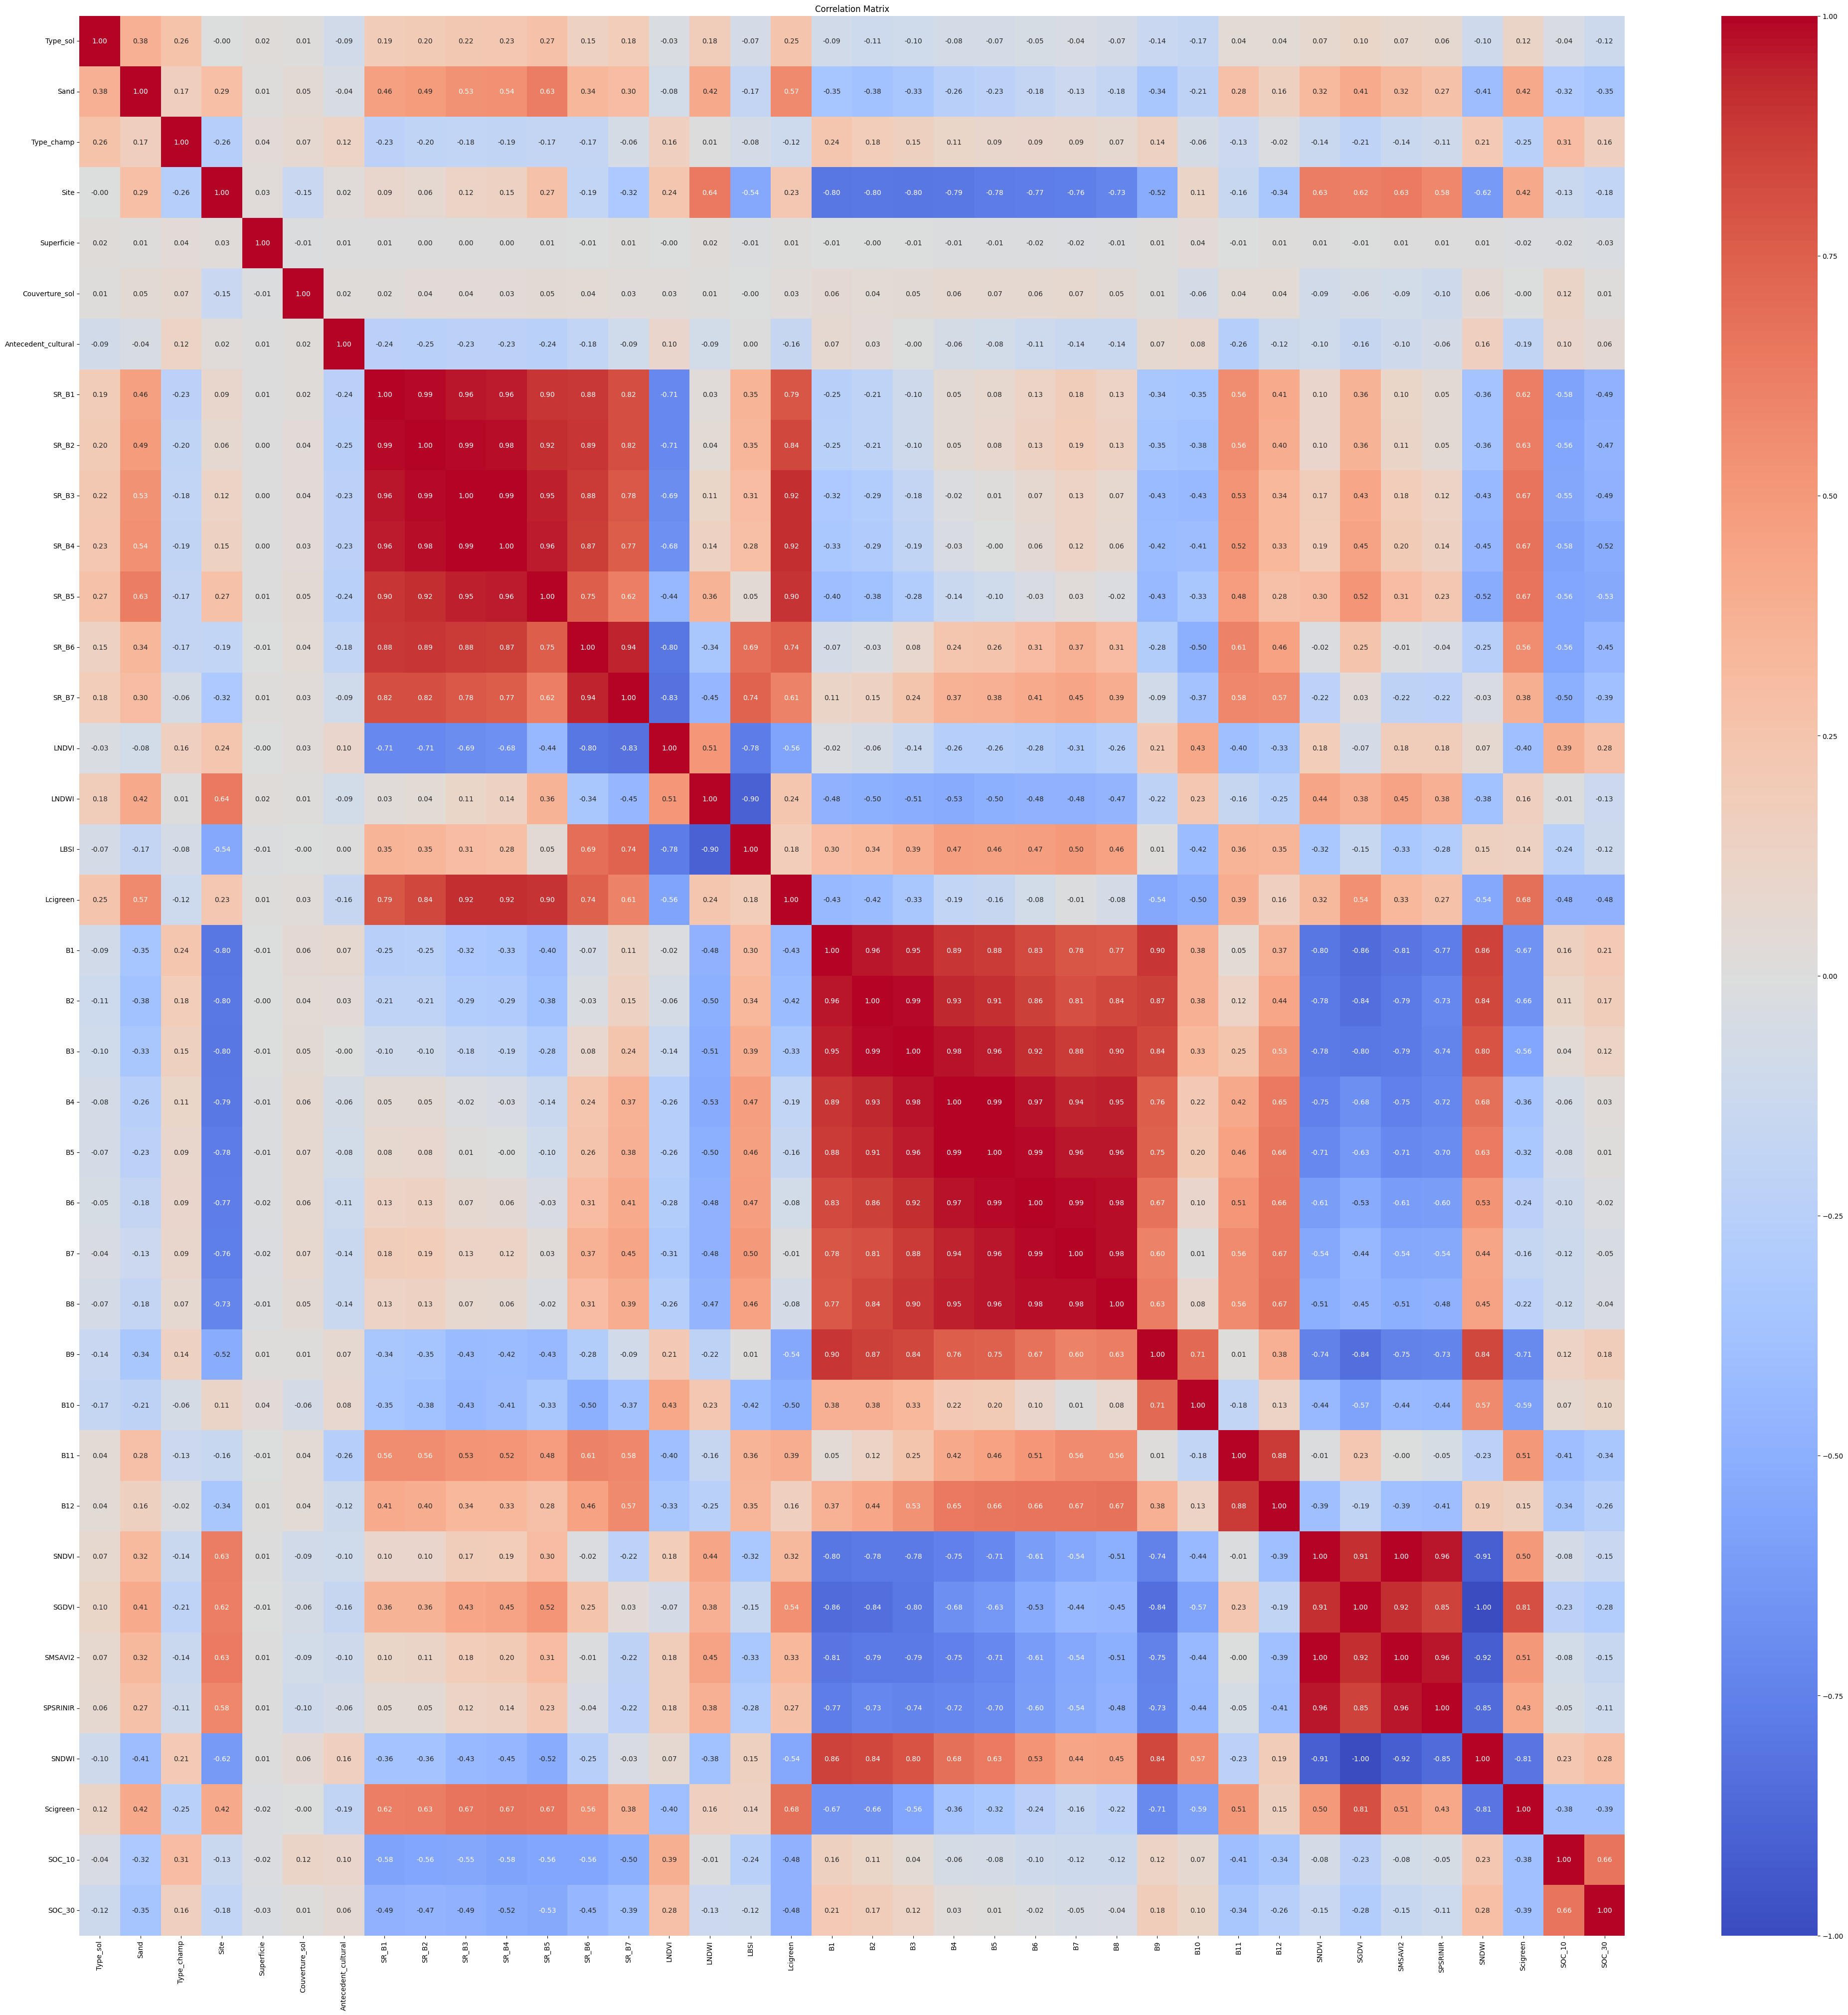

In [44]:
corr_matrix = data_train_sentinel_landsat[[ 'Type_sol', 'Sand',  'Type_champ', 'Site',   'Couverture_sol', 'Antecedent_cultural','SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7','LNDVI','LNDWI','LBSI', 'Lcigreen', 'B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen','SOC_10','SOC_30']].corr()
plt.figure(figsize=(50, 50))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [45]:
X_10 =  data_train_sentinel_landsat[[ 'Type_sol', 'Sand',  'Type_champ', 'Site',   'Couverture_sol', 'Antecedent_cultural','SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7','LNDVI','LNDWI','LBSI', 'Lcigreen', 'B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen',]].copy()

Y_10 = data_train_sentinel_landsat['SOC_10'].copy()
Y_30 = data_train_sentinel_landsat['SOC_30'].copy()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Meilleurs paramètres : {'subsample': 0.7, 'num_leaves': 31, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.01}
Meilleur score R² : 0.36778772959380696
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Meilleurs paramètres : {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Meilleur score R² : 0.3843195446390304
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Meilleurs paramètres : {'n_estimators': 800, 'max_features': 'log2', 'max_depth': None}
Meilleur score R² : 0.4031955479150771
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Meilleurs paramètres : {'max_leaf_nodes': 31, 'max_iter': 200, 'max_depth': 5, 'learning_rate': 0.05}
Meilleur score R² : 0.36618816115895503
Model: LGBMRegressor
 feature names: ['Sand', 'SR_B1', 'B9', 'Superficie', 'SR_B2', 'SR_B4', 'B10', 'LNDVI', 'SR_B5', 'SR_B3', 'LBSI', 'SR_B6', 'B8', 'Scigreen'

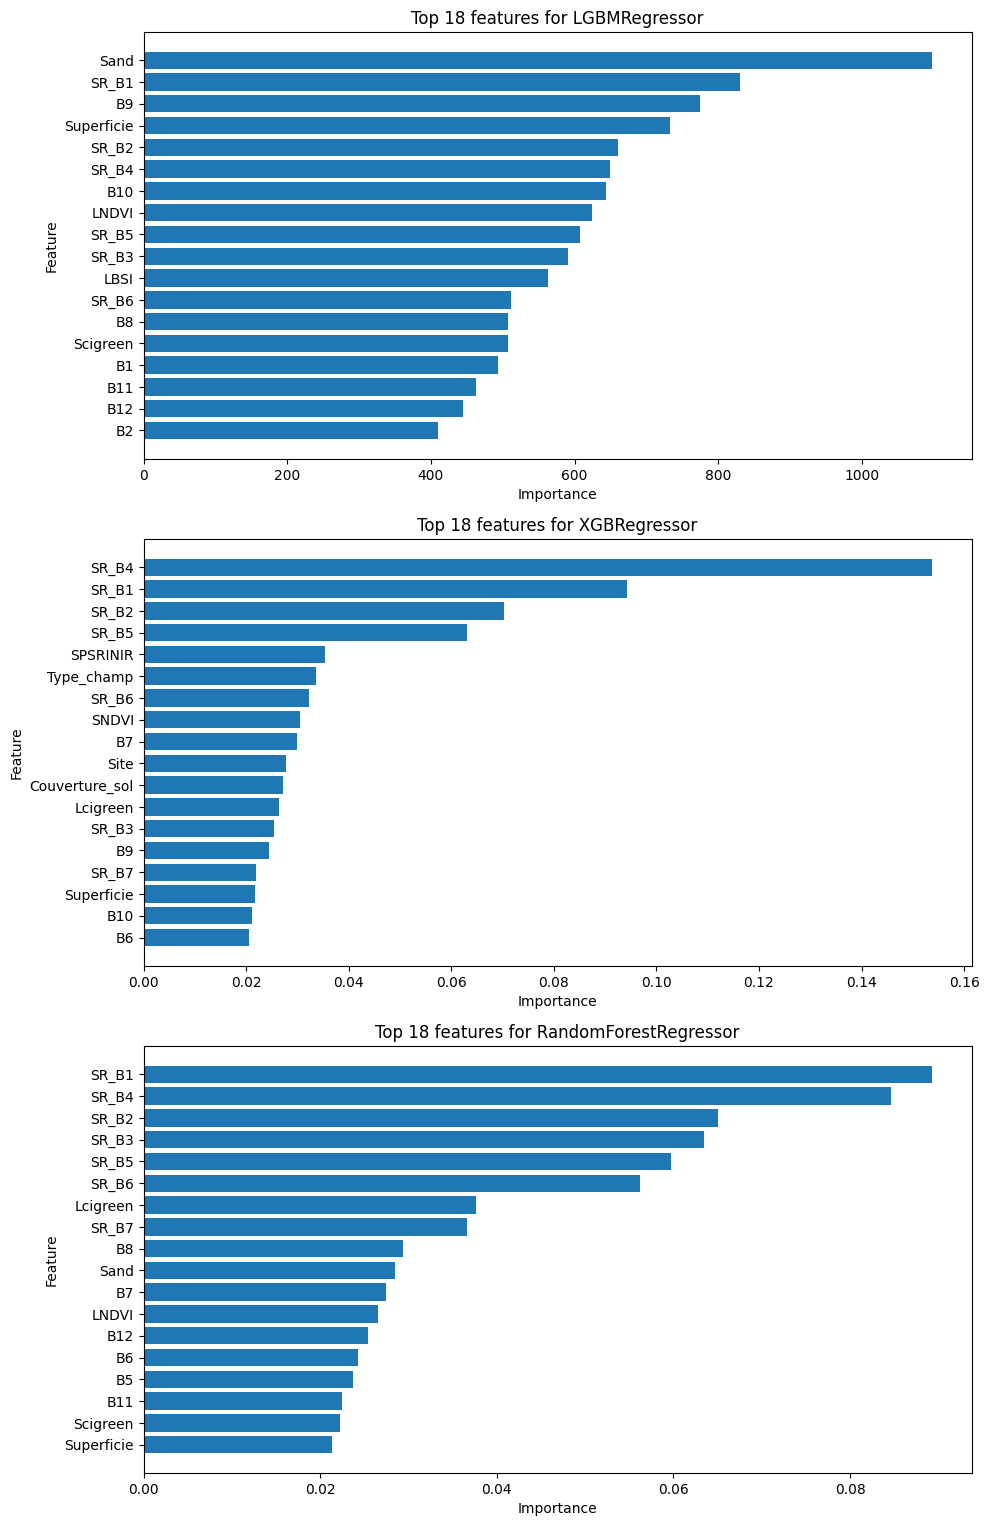

In [46]:
best_lgbm = optimize_model(lgb.LGBMRegressor(force_col_wise=True, verbosity=-1), param_grids["lgbm"], X_10, Y_10)
best_xgb = optimize_model(XGBRegressor(tree_method='hist', verbosity=0), param_grids["xgb"], X_10, Y_10)
best_rf = optimize_model(RandomForestRegressor(bootstrap=True, n_jobs=-1, random_state=42, verbose=0), param_grids["rf"], X_10, Y_10)
best_hgb = optimize_model(HistGradientBoostingRegressor(early_stopping=True,max_iter=500, random_state=42, verbose=0), param_grids["hgb"], X_10, Y_10)
plot_feature_importances([best_lgbm, best_xgb, best_rf, best_hgb], X_10.columns, top_n=18)

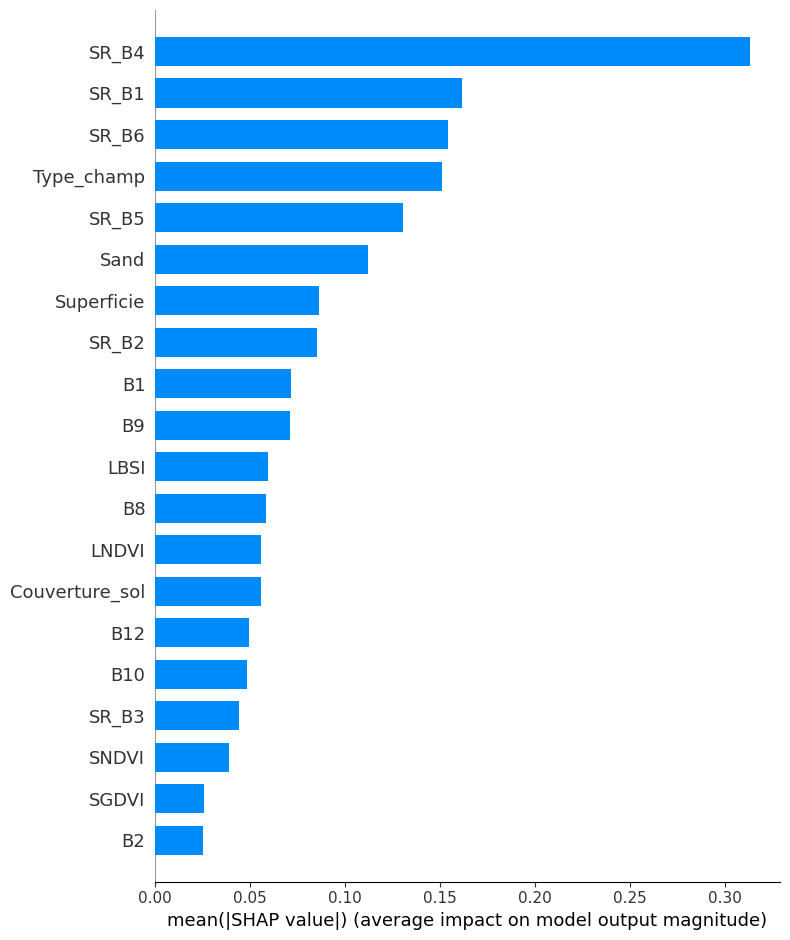

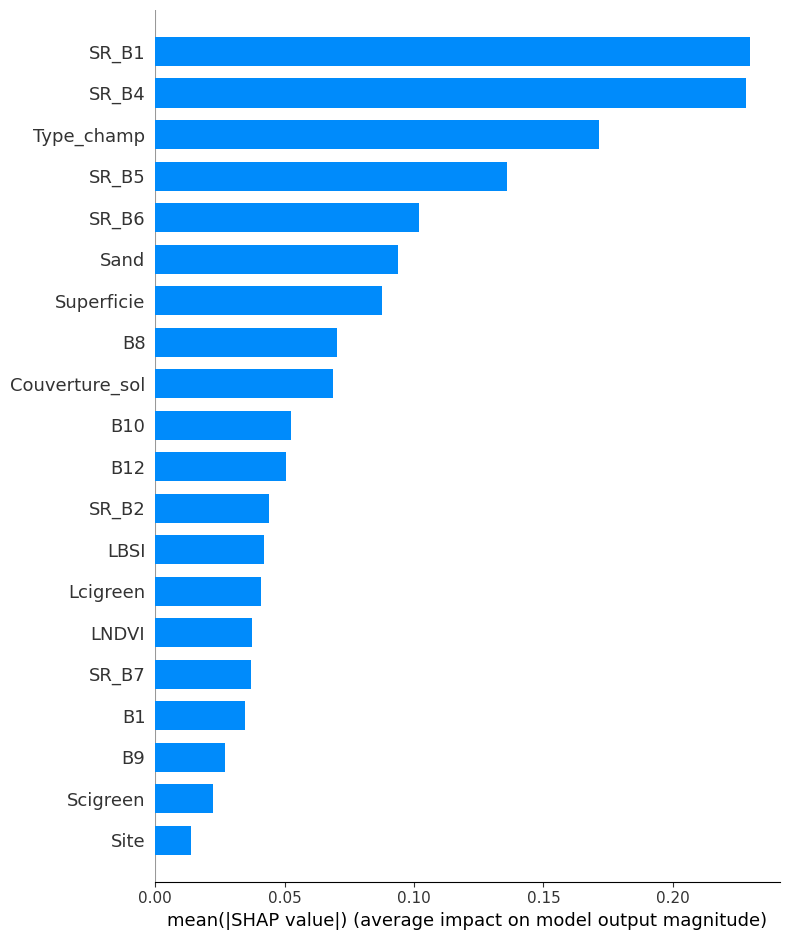

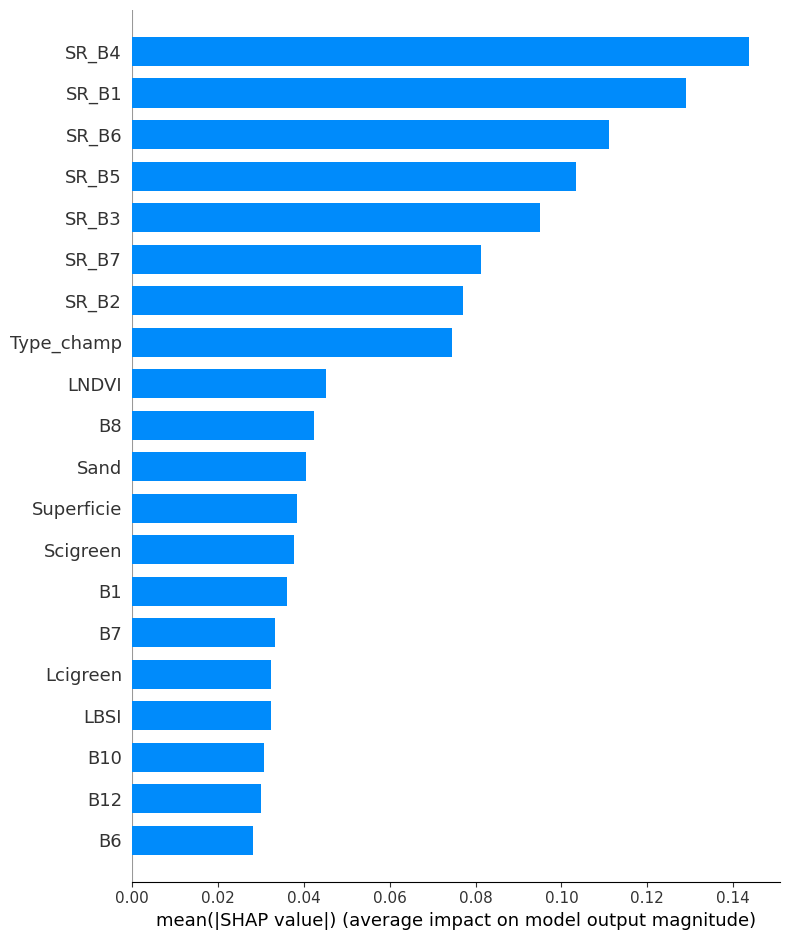

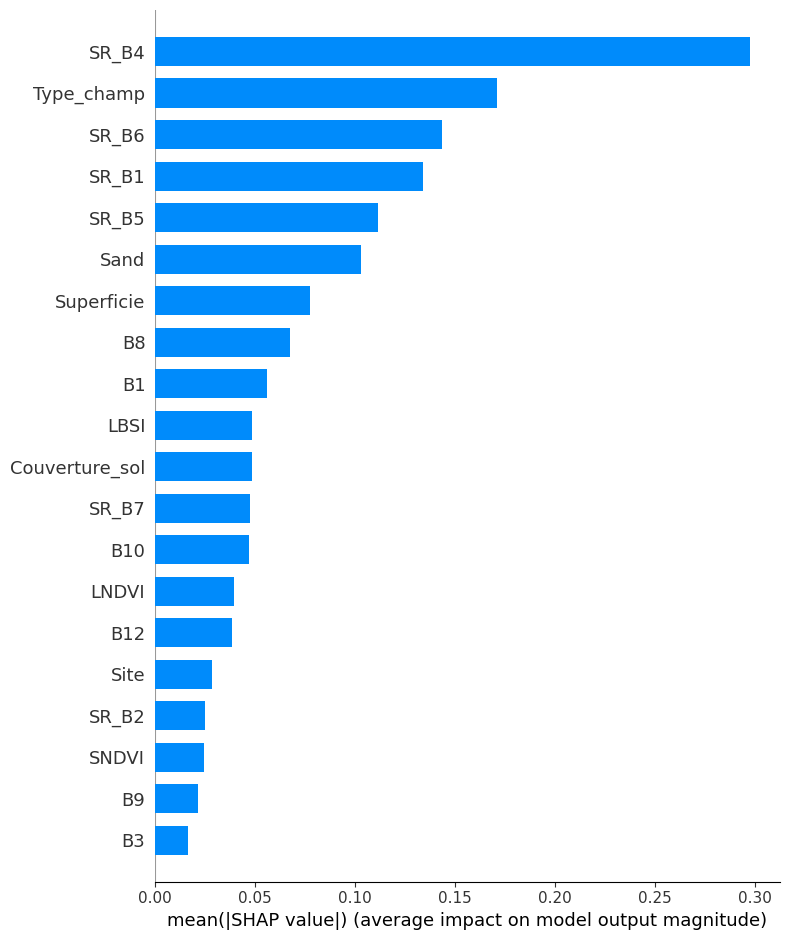

In [47]:
models = [best_lgbm, best_xgb, best_rf, best_hgb]

plt.figure(figsize=(10, 5 * len(models)))
plt.subplots_adjust(hspace=0.5)
for i, model in enumerate(models):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_10)
    shap.summary_plot(shap_values, X_10, plot_type="bar")

In [48]:

groups = data_train_sentinel_landsat["Site"]  # colonne identifiant le village
gkf = GroupKFold(n_splits=3)
for train_idx, test_idx in gkf.split(X_10, Y_10, groups):
    X_train_split, X_test_split = X_10.iloc[train_idx], X_10.iloc[test_idx]
    Y_train_split_10, Y_test_split_10 = Y_10.iloc[train_idx], Y_10.iloc[test_idx]
    Y_train_split_30, Y_test_split_30 = Y_30.iloc[train_idx], Y_30.iloc[test_idx]

In [49]:
model_10 = train(X_train_split[['Type_sol', 'Sand', 'Type_champ', 'Site',  'Couverture_sol', 'Antecedent_cultural','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen']], Y_train_split_10, 
                 X_test_split[['Type_sol', 'Sand', 'Type_champ', 'Site', 'Couverture_sol', 'Antecedent_cultural','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen']], Y_test_split_10,)


lgbmr - R²: 0.580 - RMSE: 1.089
gbr - R²: 0.573 - RMSE: 1.106
XGBRegressor - R²: 0.575 - RMSE: 1.101
HistGradientBoostingRegressor - R²: 0.627 - RMSE: 0.965
RandomForestRegressor - R²: 0.567 - RMSE: 1.121
Root Mean Squared Error (MSE) on training set: 0.7647304207554605
Root Mean Squared Error (MSE) on test set: 0.9781724830523832
Coefficient de détermination (R²) ON Train: 0.780954526842523
Coefficient de détermination (R²) ON Test: 0.6305735996885327


In [50]:
model_10 = train(X_train_split[['Type_sol', 'Sand', 'Type_champ', 'Site', 'Superficie', 'Couverture_sol', 'Antecedent_cultural','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen']], Y_train_split_10, 
                 X_test_split[['Type_sol', 'Sand', 'Type_champ', 'Site', 'Superficie', 'Couverture_sol', 'Antecedent_cultural','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen']], Y_test_split_10,)


lgbmr - R²: 0.580 - RMSE: 1.089
gbr - R²: 0.601 - RMSE: 1.034
XGBRegressor - R²: 0.575 - RMSE: 1.101
HistGradientBoostingRegressor - R²: 0.627 - RMSE: 0.965
RandomForestRegressor - R²: 0.567 - RMSE: 1.121
Root Mean Squared Error (MSE) on training set: 0.7463748555140397
Root Mean Squared Error (MSE) on test set: 0.9799396381692741
Coefficient de détermination (R²) ON Train: 0.7913436772511462
Coefficient de détermination (R²) ON Test: 0.629237591027672


In [51]:
model_10 = train(X_train_split[['Type_sol', 'Sand', 'Type_champ', 'Site', 'Superficie', 'Couverture_sol', 'Antecedent_cultural','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12']], Y_train_split_10, 
                 X_test_split[['Type_sol', 'Sand', 'Type_champ', 'Site', 'Superficie', 'Couverture_sol', 'Antecedent_cultural','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12']], Y_test_split_10,)


lgbmr - R²: 0.549 - RMSE: 1.168
gbr - R²: 0.506 - RMSE: 1.280
XGBRegressor - R²: 0.551 - RMSE: 1.162
HistGradientBoostingRegressor - R²: 0.606 - RMSE: 1.020
RandomForestRegressor - R²: 0.562 - RMSE: 1.134
Root Mean Squared Error (MSE) on training set: 0.7510089658369099
Root Mean Squared Error (MSE) on test set: 1.0355519184763742
Coefficient de détermination (R²) ON Train: 0.7887446127698767
Coefficient de détermination (R²) ON Test: 0.5859614296743383


In [52]:
# pythorch neural networwork 
from torch import nn

class model(nn.Module):
    def __init__(self, input_dim):
        super(model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):0
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

IndentationError: unexpected indent (997085323.py, line 14)